In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats
from collections import deque

In [3]:
"""
for google colab support
"""

from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/BA/4Colors10k'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['Baseline_4Colors.csv', 'Kopie von 4Colors.ipynb', 'cities.csv', 'combined_4Color.csv', 'combined_MUL_4Color.csv', 'combined_MUL_DC_sum_4Color.csv', 'combined_MUL_DC_sum_repeat_4Color.csv', 'combined_MUL_repeat_4Color.csv', 'combined_SUM_4Color.csv', 'combined_SUM_DC_sum_4Color.csv', 'combined_SUM_DC_sum_repeat_4Color.csv', 'combined_SUM_repeat_4Color.csv', 'combined_repeat_4Color.csv', 'disease_counters.csv', 'edges.csv', 'highest_degree_4Color.csv', 'highest_degree_repeat_4Color.csv', 'most_cubes_4Color.csv', 'most_cubes_repeat_4Color.csv', 'node_positions.csv', 'random_4Color.csv', 'random_repeat_4Color.csv']


In [ ]:
# Load CSV files
current_directory = os.getcwd()

# Navigate one folder up
parent_directory = os.path.dirname(current_directory)

# Construct the path to the "CSV-Files" folder
csv_files_folder = os.path.join(parent_directory, "CSV-Files ")

file_path = os.path.join(csv_files_folder, "cities.csv")

cities_df = pd.read_csv(file_path, index_col='City')

file_path = os.path.join(csv_files_folder, "disease_counters.csv")

disease_counters_df = pd.read_csv(file_path, index_col='City')

file_path = os.path.join(csv_files_folder, "edges.csv")

edges_df = pd.read_csv(file_path)

file_path = os.path.join(csv_files_folder, "node_positions.csv")

positions_df = pd.read_csv(file_path, index_col='City')

In [ ]:
colors = ['yellow', 'blue', 'black', 'red']

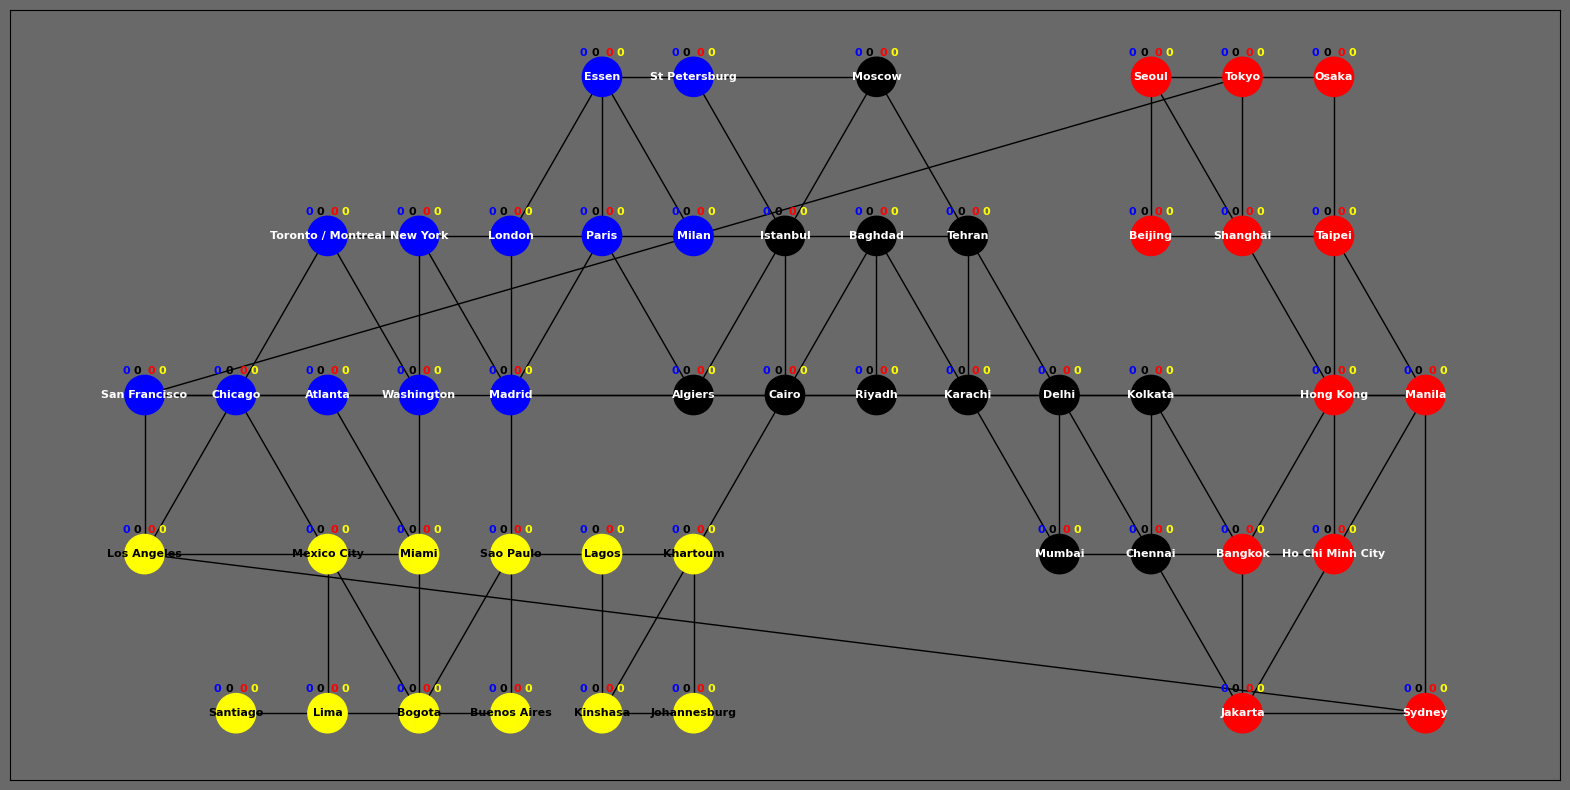

In [ ]:
# Create an empty graph
Graph_gameboard = nx.Graph()

# Add nodes with attributes
for city, color in cities_df['Color'].items():
    Graph_gameboard.add_node(city, color=color)

# Add edges from DataFrame
Graph_gameboard.add_edges_from(edges_df.values)

# Set node attributes for disease counters
for city, counters in disease_counters_df.iterrows():
    Graph_gameboard.nodes[city]['disease_counters'] = counters.to_dict()

# Define node positions
node_positions = positions_df.apply(tuple, axis=1).to_dict()

fig, ax = plt.subplots(figsize=(20, 10))

node_colors = [cities_df.loc[city, 'Color'] for city in Graph_gameboard.nodes()]

# change font of nodes with yellow color
yellow_nodes = [city for city, color in cities_df['Color'].items() if color == 'yellow']
font_colors = {city: 'black' if city in yellow_nodes else 'white' for city in Graph_gameboard.nodes()}

# Draw the nodes
nx.draw_networkx_nodes(Graph_gameboard, pos=node_positions, node_color=node_colors, node_size=800)

# Draw the edges
nx.draw_networkx_edges(Graph_gameboard, pos=node_positions)

# Add labels manually with specified colors
for node, (x, y) in node_positions.items():
    plt.text(x, y, node, fontsize=8, ha='center', va='center', color=font_colors[node], weight='bold')

ax.set_facecolor('#696969')
fig.set_facecolor('#696969')

font_colors_city_names = {city: 'black' if city in yellow_nodes else 'white' for city in Graph_gameboard.nodes()}

for node, (x, y) in node_positions.items():
    counters = Graph_gameboard.nodes[node]['disease_counters']

    # Construct labels for each counter with its color
    blue_label = f"{counters['blue']}"
    black_label = f"{counters['black']}"
    red_label = f"{counters['red']}"
    yellow_label = f"{counters['yellow']}"

    # Draw the text for each counter with its color
    plt.text(x - 4, y + 3, blue_label, fontsize=8, ha='center', va='center', color='blue', weight='bold')
    plt.text(x - 1.5, y + 3, black_label, fontsize=8, ha='center', va='center', color='black', weight='bold')
    plt.text(x + 1.5, y + 3, red_label, fontsize=8, ha='center', va='center', color='red', weight='bold')
    plt.text(x + 4, y + 3, yellow_label, fontsize=8, ha='center', va='center', color='yellow', weight='bold')

plt.show()

In [ ]:
degree_manila = Graph_gameboard.degree('Manila')
print("Degree of Manila:", degree_manila)


Degree of Manila: 5


In [ ]:
# Calculate degrees of all nodes
node_degrees = dict(Graph_gameboard.degree())

# Sort nodes based on their degree in descending order
sorted_nodes_by_degree = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)

# Get the highest degree
highest_degree = sorted_nodes_by_degree[0][1]

# Print nodes with the highest degree
print("Nodes with the highest degree:")
for node, degree in sorted_nodes_by_degree:
    if degree == highest_degree:
        print(node, ":", degree)
    else:
        break  # Stop when the degree decreases


Nodes with the highest degree:
Istanbul : 6
Hong Kong : 6


# **Helperfunctions**

---

In [ ]:
#@title initialize_pandemic_model
# Initialize the infected cities and the infection_discard_stack, infection_stack, player_stack
def initialize_pandemic_model(graph, strategy, k_action = 4, epidemic_cards = 6, nodes_to_infect_at_start = 3):
    # 96 Cubes 24 in 4 Colors
    # 48 cities
    # 6 Epidemic card
    # Infection rate 7 tiles, (2,2,2,3,3,4,4)
    # Outbreak marker 8 tiles

    # Get and shuffle all Nodes
    num_nodes = graph.number_of_nodes()
    all_nodes = list(graph.nodes)
    random.shuffle(all_nodes)

    # Initialize stacks
    infection_discard_stack = deque()
    infection_stack = deque(all_nodes)
    player_stack = deque()

    # k Nodes to infect at the start (Pandemic normal value is 3x3, 3x2, 3x1 total 9 nodes)
    # Needs to be set to 3 so we do 3 times the different infection counts
    k_nodes_to_infect = nodes_to_infect_at_start

    # Set the amount of epidemic cards (4,5,6 Pandemic)
    epidemics = epidemic_cards

    infection_rate = [2, 2, 2, 3, 3, 4, 4]
    infection_rate_counter = 0
    outbreak_counter = 0

    k_actions = k_action

    # Set the disinfection strategy
    disinfection_strategy = strategy

    # -------------------------------
    # Start of Epidemic Cards Setup
    # -------------------------------
    if not epidemics == 0:

        # Calculate the chunk size for the epidemics (Floor division)
        chunk_size = num_nodes // epidemics

        # Add chunks with one epidemic node to the player deck
        for i in range(epidemics):
            if i == epidemics - 1:
                chunk = random.sample(all_nodes, len(all_nodes))
            else:
                chunk = random.sample(all_nodes, chunk_size)

            chunk.extend(["Epidemic"])
            random.shuffle(chunk)
            player_stack.extend(chunk)

            # Remove nodes used in this chunk
            all_nodes = list(set(all_nodes) - set(chunk))
    else:
        chunk = random.sample(all_nodes, len(all_nodes))
        random.shuffle(chunk)
        player_stack.extend(chunk)

    #while (epidemics == 1 or epidemics == 2) and player_stack[-1] == "Epidemic":
        #random.shuffle(player_stack)

    # Shuffle the deque in-place
    #random.shuffle(player_stack)
    # -------------------------------
    # End of Epidemic Cards Setup
    # -------------------------------

    # -------------------------------
    # Start of Node infection
    # -------------------------------

    # Infect k nodes with 3 disease counters (blue)
    for node in infection_stack:
        for color in colors:
            graph.nodes[node]["disease_counters"][color] = 0

    for _ in range(k_nodes_to_infect):
        node = infection_stack.pop()
        node_color = graph.nodes[node]['color']
        graph.nodes[node]["disease_counters"][node_color] = 3
        infection_discard_stack.append(node)

    # Infect k nodes with 2 disease counters
    for _ in range(k_nodes_to_infect):
        node = infection_stack.pop()
        node_color = graph.nodes[node]['color']
        graph.nodes[node]["disease_counters"][node_color] = 2
        infection_discard_stack.append(node)

    # Infect k nodes with 1 disease counter
    for _ in range(k_nodes_to_infect):
        node = infection_stack.pop()
        node_color = graph.nodes[node]['color']
        graph.nodes[node]["disease_counters"][node_color] = 1
        infection_discard_stack.append(node)

    # -------------------------------
    # End of Node infection
    # -------------------------------

    # Set node attributes
    #nx.set_node_attributes(graph, 0, "disease_counters")

    # Initialize the sisr_model
    pandemic_model = {"graph": graph,
                      "infection_stack": infection_stack,
                      "infection_discard_stack": infection_discard_stack,
                      "player_stack": player_stack,
                      "infection_rate": infection_rate,
                      "infection_rate_counter": infection_rate_counter,
                      "outbreak_counter": outbreak_counter,
                      "disinfection_strategy": disinfection_strategy,
                      "k_actions": k_actions,
                      "epidemic_cards": epidemics,
                      "nodes_to_infect_at_start": nodes_to_infect_at_start}

    return pandemic_model

In [ ]:
#@title Outbreak
# Outbreak logi
def outbreak(graph, node, color, outbreak_nodes=None, outbreak_counter=0):

    # Set of Nodes that had an Outbreak (1 Outbreak per iteration)
    if outbreak_nodes is None:
        outbreak_nodes = set()  # Initialize the set of nodes that have had an outbreak
    outbreak_nodes.add(node)  # Add the current node to the set

    connected_nodes = graph.neighbors(node)
    #print(connected_nodes)

    # Infect every neighbour
    for cn in connected_nodes:
        if cn not in outbreak_nodes:  # Only process the node if it hasn't had an outbreak yet
            if(graph.nodes[cn]['disease_counters'][color] == 3):
                outbreak(graph, cn, color, outbreak_nodes, outbreak_counter + 1)
            else:
                graph.nodes[cn]['disease_counters'][color] += 1

    return outbreak_counter

# **Disinfect**

---

In [ ]:
#@title Strategy 0: Baseline disinfect
def baseline_disinfection(graph, k):
    pass

In [ ]:
#@title Strategy 1: Randomly Disinfect Nodes (one Cube per Node per Turn)
def random_disinfection(graph, k):
    # Randomly disinfect k nodes with a blue disease counter greater than 0
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]
    nodes_to_disinfect = random.sample(nodes_to_disinfect, min(k, len(nodes_to_disinfect)))

    for node in nodes_to_disinfect:
        colors_to_disinfect = [color for color in colors if graph.nodes[node]["disease_counters"][color] > 0]
        color_to_disinfect = random.choice(colors_to_disinfect)
        graph.nodes[node]["disease_counters"][color_to_disinfect] -= 1

In [ ]:
#@title Strategy 1: Randomly Disinfect Nodes (Nodes can repeat)
def random_disinfection_repeat(graph, k):
    # Get nodes with a blue disease counter greater than 0
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Initialize disinfection count
    disinfection_count = 0

    while nodes_to_disinfect and disinfection_count < k:
        # Randomly select a node to disinfect
        node_to_disinfect = random.choice(nodes_to_disinfect)

        # Decrease the disease counter for the selected node
        colors_to_disinfect = [color for color in colors if graph.nodes[node_to_disinfect]["disease_counters"][color] > 0]
        color_to_disinfect = random.choice(colors_to_disinfect)
        graph.nodes[node_to_disinfect]["disease_counters"][color_to_disinfect] -= 1

        # Increment disinfection count
        disinfection_count += 1

        # If the counters become 0, remove the node from the list
        if all(value == 0 for value in graph.nodes[node_to_disinfect]["disease_counters"].values()):
            nodes_to_disinfect.remove(node_to_disinfect)

In [ ]:
#@title Strategy 2: Disinfect Nodes with Most Cubes

def disinfect_most_cubes(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: sum(graph.nodes[node]["disease_counters"].values()), reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        colors_to_disinfect = [color for color in colors if graph.nodes[node]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)

        # Decrease the disease counter for the color with the highest count
        graph.nodes[node]["disease_counters"][color_to_disinfect] -= 1

In [ ]:
#@title Strategy 2: Disinfect Nodes with Most Cubes (Nodes can repeat)
def disinfect_most_cubes_repeat(graph, k):
    # Get nodes with a blue disease counter greater than 0
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Sort nodes by blue disease counter
    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: sum(graph.nodes[node]["disease_counters"].values()), reverse=True)

    # Initialize disinfection count
    disinfection_count = 0

    while nodes_to_disinfect and disinfection_count < k:
        # Select the node with the most cubes
        node_to_disinfect = nodes_to_disinfect[0]

        colors_to_disinfect = [color for color in colors if graph.nodes[node_to_disinfect]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node_to_disinfect]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node_to_disinfect]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node_to_disinfect]["disease_counters"][color_to_disinfect] -= 1

        disinfection_count += 1

        # If the counters become 0, remove the node from the list
        if all(value == 0 for value in graph.nodes[node_to_disinfect]["disease_counters"].values()):
            nodes_to_disinfect.remove(node_to_disinfect)

        nodes_to_disinfect.sort(key=lambda node:  sum(graph.nodes[node]["disease_counters"].values()), reverse=True)

In [ ]:
#@title Strategy 3: Disinfect Nodes with Highest Degree

def disinfect_highest_degree(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: graph.degree[node], reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:

        """
        Deterministic will always take the first max value
        # Find the color with the highest disease counter
        max_color = max(graph.nodes[node]["disease_counters"], key=graph.nodes[node]["disease_counters"].get)

        # Decrease the disease counter for the color with the highest count
        graph.nodes[node]["disease_counters"][max_color] -= 1
        """

        # Random betwee max values
        colors_to_disinfect = [color for color in colors if graph.nodes[node]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node]["disease_counters"][color_to_disinfect] -= 1

In [ ]:
#@title Strategy 3: Disinfect Nodes with Highest Degree (repeat)

def disinfect_highest_degree_repeat(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: graph.degree[node], reverse=True)

    disinfection_count = 0

    while nodes_to_disinfect and disinfection_count < k:
        node_to_disinfect = nodes_to_disinfect[0]

        colors_to_disinfect = [color for color in colors if graph.nodes[node_to_disinfect]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node_to_disinfect]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node_to_disinfect]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node_to_disinfect]["disease_counters"][color_to_disinfect] -= 1

        disinfection_count += 1

        if all(value == 0 for value in graph.nodes[node_to_disinfect]["disease_counters"].values()):
            nodes_to_disinfect.remove(node_to_disinfect)

        nodes_to_disinfect.sort(key=lambda node: graph.degree[node], reverse=True)

In [ ]:
#@title Strategy 4: Combination of Most Cubes and Highest Degree (only sort)

def disinfect_combined(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: (sum(graph.nodes[node]["disease_counters"].values()), graph.degree[node]), reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        colors_to_disinfect = [color for color in colors if graph.nodes[node]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node]["disease_counters"][color_to_disinfect] -= 1

In [ ]:
#@title Strategy 4: Combination of Most Cubes and Highest Degree (only sort)(repeat)

def disinfect_combined_repeat(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=lambda node: (sum(graph.nodes[node]["disease_counters"].values()), graph.degree[node]), reverse=True)

    disinfection_count = 0

    while nodes_to_disinfect and disinfection_count < k:
        node_to_disinfect = nodes_to_disinfect[0]

        colors_to_disinfect = [color for color in colors if graph.nodes[node_to_disinfect]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node_to_disinfect]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node_to_disinfect]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node_to_disinfect]["disease_counters"][color_to_disinfect] -= 1

        disinfection_count += 1

        if all(value == 0 for value in graph.nodes[node_to_disinfect]["disease_counters"].values()):
            nodes_to_disinfect.remove(node_to_disinfect)

        nodes_to_disinfect.sort(key=lambda node: (sum(graph.nodes[node]["disease_counters"].values()), graph.degree[node]), reverse=True)

In [ ]:
#@title Strategy 5: Combination of Most Cubes and Highest Degree (SUM function)

def disinfect_combined_sum(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = min(3, max(graph.nodes[node]["disease_counters"].values()))
        return degree_score + disease_score

    # Sort the nodes based on the score
    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        colors_to_disinfect = [color for color in colors if graph.nodes[node]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node]["disease_counters"][color_to_disinfect] -= 1


In [ ]:
#@title Strategy 5: Combination of Most Cubes and Highest Degree (SUM function)(repeat)
def disinfect_combined_sum_repeat(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = min(3, max(graph.nodes[node]["disease_counters"].values()))
        return degree_score + disease_score

    disinfection_count = 0

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)

    while nodes_to_disinfect and disinfection_count < k:
        node_to_disinfect = nodes_to_disinfect[0]

        colors_to_disinfect = [color for color in colors if graph.nodes[node_to_disinfect]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node_to_disinfect]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node_to_disinfect]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node_to_disinfect]["disease_counters"][color_to_disinfect] -= 1

        disinfection_count += 1

        if all(value == 0 for value in graph.nodes[node_to_disinfect]["disease_counters"].values()):
            nodes_to_disinfect.remove(node_to_disinfect)

        # Sort the nodes based on the score
        nodes_to_disinfect.sort(key=calculate_score, reverse=True)

In [ ]:
#@title Strategy 5: Combination of Most Cubes and Highest Degree (SUM function / Disease counters sum e.g. [3,3,3,3] was before 3 and now it would be 12)

def disinfect_combined_sum_disease_counter_sum(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = max(0, sum(graph.nodes[node]["disease_counters"].values()))
        return degree_score + disease_score

    # Sort the nodes based on the score
    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        colors_to_disinfect = [color for color in colors if graph.nodes[node]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node]["disease_counters"][color_to_disinfect] -= 1


In [ ]:
#@title Strategy 5: Combination of Most Cubes and Highest Degree (SUM function / Disease counters sum)(repeat)
def disinfect_combined_sum_disease_counter_sum_repeat(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = max(0, sum(graph.nodes[node]["disease_counters"].values()))
        return degree_score + disease_score

    disinfection_count = 0

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)

    while nodes_to_disinfect and disinfection_count < k:
        node_to_disinfect = nodes_to_disinfect[0]

        colors_to_disinfect = [color for color in colors if graph.nodes[node_to_disinfect]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node_to_disinfect]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node_to_disinfect]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node_to_disinfect]["disease_counters"][color_to_disinfect] -= 1

        disinfection_count += 1

        if all(value == 0 for value in graph.nodes[node_to_disinfect]["disease_counters"].values()):
            nodes_to_disinfect.remove(node_to_disinfect)

        # Sort the nodes based on the score
        nodes_to_disinfect.sort(key=calculate_score, reverse=True)

In [ ]:
#@title Strategy 6: Combination of Most Cubes and Highest Degree (MUL function)
def disinfect_combined_mul(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = min(3, max(graph.nodes[node]["disease_counters"].values()))
        return degree_score * disease_score

    # Sort the nodes based on the score
    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        colors_to_disinfect = [color for color in colors if graph.nodes[node]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node]["disease_counters"][color_to_disinfect] -= 1


In [ ]:
#@title Strategy 6: Combination of Most Cubes and Highest Degree (MUL function)(repeat)
def disinfect_combined_mul_repeat(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = min(3, max(graph.nodes[node]["disease_counters"].values()))
        return degree_score * disease_score

    disinfection_count = 0

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)

    while nodes_to_disinfect and disinfection_count < k:
        node_to_disinfect = nodes_to_disinfect[0]

        colors_to_disinfect = [color for color in colors if graph.nodes[node_to_disinfect]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node_to_disinfect]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node_to_disinfect]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node_to_disinfect]["disease_counters"][color_to_disinfect] -= 1

        disinfection_count += 1

        if all(value == 0 for value in graph.nodes[node_to_disinfect]["disease_counters"].values()):
            nodes_to_disinfect.remove(node_to_disinfect)

        # Sort the nodes based on the score
        nodes_to_disinfect.sort(key=calculate_score, reverse=True)

In [ ]:
#@title Strategy 6: Combination of Most Cubes and Highest Degree (MUL function / Disease counters sum)
def disinfect_combined_mul_disease_counter_sum(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = max(0, sum(graph.nodes[node]["disease_counters"].values()))
        return degree_score * disease_score

    # Sort the nodes based on the score
    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)
    nodes_to_disinfect = nodes_to_disinfect[:k]

    for node in nodes_to_disinfect:
        colors_to_disinfect = [color for color in colors if graph.nodes[node]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node]["disease_counters"][color_to_disinfect] -= 1


In [ ]:
#@title Strategy 6: Combination of Most Cubes and Highest Degree (MUL function)(repeat)
def disinfect_combined_mul_disease_counter_sum_repeat(graph, k):
    nodes_to_disinfect = [node for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)]

    # Define a function to calculate the score for a node
    def calculate_score(node):
        degree_score = min(6, graph.degree[node])
        disease_score = max(0, sum(graph.nodes[node]["disease_counters"].values()))
        return degree_score * disease_score

    disinfection_count = 0

    nodes_to_disinfect = sorted(nodes_to_disinfect, key=calculate_score, reverse=True)

    while nodes_to_disinfect and disinfection_count < k:
        node_to_disinfect = nodes_to_disinfect[0]

        colors_to_disinfect = [color for color in colors if graph.nodes[node_to_disinfect]["disease_counters"][color] > 0]
        max_disease_counter = max(graph.nodes[node_to_disinfect]["disease_counters"].values())
        max_colors = [color for color in colors_to_disinfect if graph.nodes[node_to_disinfect]["disease_counters"][color] == max_disease_counter]
        color_to_disinfect = random.choice(max_colors)
        graph.nodes[node_to_disinfect]["disease_counters"][color_to_disinfect] -= 1

        disinfection_count += 1

        if all(value == 0 for value in graph.nodes[node_to_disinfect]["disease_counters"].values()):
            nodes_to_disinfect.remove(node_to_disinfect)

        # Sort the nodes based on the score
        nodes_to_disinfect.sort(key=calculate_score, reverse=True)

# **Simulation and CSV creation
**

---

In [ ]:
#@title Simulation and CSV creation

def simulate_pandemic(model, num_steps, run):
    graph = model["graph"]  # Get the graph and stacks from the model
    infection_stack = model["infection_stack"]
    infection_discard_stack = model["infection_discard_stack"]
    player_stack = model["player_stack"]
    infection_rate = model["infection_rate"] # [2, 2, 2, 3, 3, 4, 4]
    infection_rate_counter = model["infection_rate_counter"]
    outbreak_counter = model["outbreak_counter"]
    disinfection_strategy = model["disinfection_strategy"]
    k_actions = model["k_actions"]
    epidemics = model["epidemic_cards"]
    nodes_to_infect_at_start = model["nodes_to_infect_at_start"]

    # Initialize lists to store statistics for each step
    statistics = []
    epidemic_counter = 0
    player_deck_empty  = False

    # Add the init step to the CSV-file
    statistics.append({
        'setup': disinfection_strategy,
        'run': run,  # Index of simulation run
        'k_actions': k_actions,
        'no_epidemic': epidemics,
        'timestep': -1,
        'susceptible_nodes': sum(1 for node in graph.nodes if all(graph.nodes[node]["disease_counters"][color] == 0 for color in colors)),
        'infected_nodes': sum(1 for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors)),

        'infection_1_nodes_blue': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 1),
        'infection_2_nodes_blue': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 2),
        'infection_3_nodes_blue': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 3),

        'infection_1_nodes_yellow': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["yellow"] == 1),
        'infection_2_nodes_yellow': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["yellow"] == 2),
        'infection_3_nodes_yellow': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["yellow"] == 3),

        'infection_1_nodes_red': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["red"] == 1),
        'infection_2_nodes_red': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["red"] == 2),
        'infection_3_nodes_red': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["red"] == 3),

        'infection_1_nodes_black': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["black"] == 1),
        'infection_2_nodes_black': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["black"] == 2),
        'infection_3_nodes_black': sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["black"] == 3),

        'epidemic_cards_drawn': epidemic_counter,
        'outbreaks': outbreak_counter,
        'deck_empty': player_deck_empty,
        'player_stack': len(player_stack),
        'infection_stack': len(infection_stack),
        'infection_discard_stack': len(infection_discard_stack),
        'infection_rate_counter': infection_rate_counter
    })

    for step in range(num_steps):
        # Perform actions (disinfection)
        if disinfection_strategy == "baseline":
            baseline_disinfection(graph, k_actions)
        elif disinfection_strategy == "random":
            random_disinfection(graph, k_actions)
        elif disinfection_strategy == "random_repeat":
            random_disinfection_repeat(graph, k_actions)
        elif disinfection_strategy == "most_cubes":
            disinfect_most_cubes(graph, k_actions)
        elif disinfection_strategy == "most_cubes_repeat":
            disinfect_most_cubes_repeat(graph, k_actions)
        elif disinfection_strategy == "highest_degree":
            disinfect_highest_degree(graph, k_actions)
        elif disinfection_strategy == "highest_degree_repeat":
            disinfect_highest_degree_repeat(graph, k_actions)
        elif disinfection_strategy == "combined":
            disinfect_combined(graph, k_actions)
        elif disinfection_strategy == "combined_repeat":
            disinfect_combined_repeat(graph, k_actions)
        elif disinfection_strategy == "combined_SUM":
            disinfect_combined_sum(graph, k_actions)
        elif disinfection_strategy == "combined_SUM_repeat":
            disinfect_combined_sum_repeat(graph, k_actions)
        elif disinfection_strategy == "combined_MUL":
            disinfect_combined_mul(graph, k_actions)
        elif disinfection_strategy == "combined_MUL_repeat":
            disinfect_combined_mul_repeat(graph, k_actions)
        elif disinfection_strategy == "combined_SUM_DC_sum":
            disinfect_combined_sum_disease_counter_sum(graph, k_actions)
        elif disinfection_strategy == "combined_SUM_DC_sum_repeat":
            disinfect_combined_sum_disease_counter_sum_repeat(graph, k_actions)
        elif disinfection_strategy == "combined_MUL_DC_sum":
            disinfect_combined_mul_disease_counter_sum(graph, k_actions)
        elif disinfection_strategy == "combined_MUL_DC_sum_repeat":
            disinfect_combined_mul_disease_counter_sum_repeat(graph, k_actions)


        # Draw 2 player stack cards
        for i in range(2):
            # Check if the stack is empty
            if player_stack:

                # Pop the card from the stack that is drawn
                card_player_drawn = player_stack.pop()

                # Since we don't have a cure we only have the Epidemic logic here
                if card_player_drawn == "Epidemic":
                    # Increment counter for stats
                    epidemic_counter += 1

                    # Infection rate will increase how many nodes get infected each round
                    infection_rate_counter += 1

                    if (infection_stack):
                        # Pop card from the left to simulate a draw from the bottem of the deck
                        node_to_outbreak = infection_stack.popleft()

                        # Add card to the discard stack
                        infection_discard_stack.append(node_to_outbreak)

                        node_to_outbreak_color = graph.nodes[node_to_outbreak]['color']

                        # Add 3 cubes to the epidemic node
                        while graph.nodes[node_to_outbreak]["disease_counters"][node_to_outbreak_color] != 3:
                            graph.nodes[node_to_outbreak]["disease_counters"][node_to_outbreak_color] += 1

                        # Call outbereak (increases the node count) and return the outbreak counter for the CSV-File
                        outbreak_counter = outbreak(graph, node_to_outbreak, node_to_outbreak_color, set(node_to_outbreak), outbreak_counter + 1)

                    # Shuffe the discard stack add it on top of the infection stack and delete all nodes from the discard stack
                    random.shuffle(infection_discard_stack)
                    infection_stack.extend(infection_discard_stack)
                    infection_discard_stack.clear()
            else:
                player_deck_empty  = True

        # Draw as many cards as infection rate and infect the cities by 1 cube
        # Game is over if no cards left for the player to draw so we end the infection
        if not player_deck_empty :
            for i in range(infection_rate[infection_rate_counter]):
                if infection_stack:
                    node_to_infect = infection_stack.pop()
                    infection_discard_stack.append(node_to_infect)
                    node_to_infect_color = graph.nodes[node_to_infect]['color']

                    disease_counter = graph.nodes[node_to_infect]["disease_counters"][node_to_infect_color]

                    if disease_counter == 3:
                        outbreak_counter = outbreak(graph, node_to_infect, node_to_infect_color, set(node_to_infect), outbreak_counter + 1)
                    else:
                        graph.nodes[node_to_infect]["disease_counters"][node_to_infect_color] += 1

        # Count node statuses
        susceptible_nodes = sum(1 for node in graph.nodes if all(graph.nodes[node]["disease_counters"][color] == 0 for color in colors))
        infected_nodes = sum(1 for node in graph.nodes if any(graph.nodes[node]["disease_counters"][color] > 0 for color in colors))

        infection_1_nodes_blue = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 1)
        infection_2_nodes_blue = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 2)
        infection_3_nodes_blue = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["blue"] == 3)

        infection_1_nodes_yellow = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["yellow"] == 1)
        infection_2_nodes_yellow = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["yellow"] == 2)
        infection_3_nodes_yellow = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["yellow"] == 3)

        infection_1_nodes_red = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["red"] == 1)
        infection_2_nodes_red = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["red"] == 2)
        infection_3_nodes_red = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["red"] == 3)

        infection_1_nodes_black = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["black"] == 1)
        infection_2_nodes_black = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["black"] == 2)
        infection_3_nodes_black = sum(1 for node in graph.nodes if graph.nodes[node]["disease_counters"]["black"] == 3)

        outbreaks = outbreak_counter

        # Append statistics for this time step
        statistics.append({
            'setup': disinfection_strategy,
            'run': run,  # Index of simulation run
            'k_actions': k_actions,
            'no_epidemic': epidemics,
            'timestep': step,
            'susceptible_nodes': susceptible_nodes,
            'infected_nodes': infected_nodes,
            'infection_1_nodes_blue': infection_1_nodes_blue,
            'infection_2_nodes_blue': infection_2_nodes_blue,
            'infection_3_nodes_blue': infection_3_nodes_blue,
            'infection_1_nodes_yellow': infection_1_nodes_yellow,
            'infection_2_nodes_yellow': infection_2_nodes_yellow,
            'infection_3_nodes_yellow': infection_3_nodes_yellow,
            'infection_1_nodes_red': infection_1_nodes_red,
            'infection_2_nodes_red': infection_2_nodes_red,
            'infection_3_nodes_red': infection_3_nodes_red,
            'infection_1_nodes_black': infection_1_nodes_black,
            'infection_2_nodes_black': infection_2_nodes_black,
            'infection_3_nodes_black': infection_3_nodes_black,
            'epidemic_cards_drawn': epidemic_counter,
            'outbreaks': outbreaks,
            'deck_empty': player_deck_empty,
            'player_stack': len(player_stack),
            'infection_stack': len(infection_stack),
            'infection_discard_stack': len(infection_discard_stack),
            'infection_rate_counter': infection_rate_counter
        })

    return statistics

In [6]:
#strategies = ["random", "random_repeat", "most_cubes", "most_cubes_repeat",
#              "highest_degree", "highest_degree_repeat", "combined",
#              "combined_repeat", "combined_SUM", "combined_SUM_repeat",
#              "combined_MUL", "combined_MUL_repeat", "combined_SUM_DC_sum",
#              "combined_SUM_DC_sum_repeat", "combined_MUL_DC_sum",
#              "combined_MUL_DC_sum_repeat"]

strategies = ["combined_SUM", "combined_SUM_repeat",
              "combined_MUL", "combined_MUL_repeat", "combined_SUM_DC_sum",
              "combined_SUM_DC_sum_repeat", "combined_MUL_DC_sum",
              "combined_MUL_DC_sum_repeat"]

num_simulations = 10000

k_actions_range = range(9)

epidemic_cards = [0,1,2,3,4,5,6]


In [ ]:
#@title Baseline creation
run = 1
data = []  # Initialize all statistics list
for k_action in k_actions_range:
    if k_action == 0:
        for epidemic in epidemic_cards:
            for num_simulation  in range(num_simulations):
                model = initialize_pandemic_model(Graph_gameboard, "baseline", k_action, epidemic, 3)

                # 48 City cards + epidemics
                # per turn a player can draw 2 cards
                num_steps = math.ceil((48 + epidemic) / 2)  # Round up to the next integer
                stats = simulate_pandemic(model, num_steps, run)
                data.extend(stats)
                run += 1

# Creating DataFrame
df = pd.DataFrame(data)

# Saving DataFrame to CSV file
df.to_csv('Baseline_4Colors.csv', index=False)

In [ ]:
#@title All other strategies

for strategy in strategies:
    run = 1
    data = []  # Initialize all statistics list

    for k_action in k_actions_range[1:]:  # Exclude the baseline k_action
        # Iterate over epidemic car
        for epidemic in epidemic_cards:
            for num_simulation in range(num_simulations):
                model = initialize_pandemic_model(Graph_gameboard, strategy, k_action, epidemic, 3)
                # Calculate number of steps based on city cards and epidemic cards
                num_steps = math.ceil((48 + epidemic) / 2)  # Round up to the next integer
                stats = simulate_pandemic(model, num_steps, run)
                data.extend(stats)  # Add the statistics to the data list
                run += 1

    # Creating DataFrame
    df = pd.DataFrame(data)

    # Saving DataFrame to CSV file
    df.to_csv(f'{strategy}_4Colors.csv', index=False)

In [ ]:
for strategy in strategies:
    run = 1

    for k_action in k_actions_range[1:]:  # Exclude the baseline k_action
        # Iterate over epidemic cards
        for epidemic in epidemic_cards:
            with open(f'{strategy}_4Color.csv', 'a') as f:
                for num_simulation in range(num_simulations):
                    model = initialize_pandemic_model(Graph_gameboard, strategy, k_action, epidemic, 3)
                    num_steps = math.ceil((48 + epidemic) / 2)  # Round up to the next integer
                    stats = simulate_pandemic(model, num_steps, run)
                    df = pd.DataFrame(stats)
                    df.to_csv(f, header=not f.tell(), index=False)  # Write DataFrame to file without header if file exists
                    run += 1

# **CSV Statistics**

---

In [ ]:
#@title Functions for stat calculation
# Function to calculate average susceptible count for each time step
def calculate_avg_susceptible(group_df):
    avg_susceptible = group_df.groupby('timestep')['susceptible_nodes'].mean()
    return avg_susceptible

# Function to calculate average infected count for each time step
def calculate_mean_infected(group_df):
    avg_infected = group_df.groupby('timestep')['infected_nodes'].mean()
    return avg_infected

# Function to calculate average counts of infected nodes (1, 2, and 3 cubes) for each time step
def calculate_avg_infected(group_df):
    avg_infected_1_blue = group_df.groupby('timestep')['infection_1_nodes_blue'].mean()
    avg_infected_2_blue = group_df.groupby('timestep')['infection_2_nodes_blue'].mean()
    avg_infected_3_blue = group_df.groupby('timestep')['infection_3_nodes_blue'].mean()

    avg_infected_1_yellow = group_df.groupby('timestep')['infection_1_nodes_yellow'].mean()
    avg_infected_2_yellow = group_df.groupby('timestep')['infection_2_nodes_yellow'].mean()
    avg_infected_3_yellow = group_df.groupby('timestep')['infection_3_nodes_yellow'].mean()

    avg_infected_1_red = group_df.groupby('timestep')['infection_1_nodes_red'].mean()
    avg_infected_2_red = group_df.groupby('timestep')['infection_2_nodes_red'].mean()
    avg_infected_3_red = group_df.groupby('timestep')['infection_3_nodes_red'].mean()

    avg_infected_1_black = group_df.groupby('timestep')['infection_1_nodes_black'].mean()
    avg_infected_2_black = group_df.groupby('timestep')['infection_2_nodes_black'].mean()
    avg_infected_3_black = group_df.groupby('timestep')['infection_3_nodes_black'].mean()

    return  (avg_infected_1_blue, avg_infected_2_blue, avg_infected_3_blue,
            avg_infected_1_yellow, avg_infected_2_yellow, avg_infected_3_yellow,
            avg_infected_1_red, avg_infected_2_red, avg_infected_3_red,
            avg_infected_1_black, avg_infected_2_black, avg_infected_3_black)

def calculate_percentage(a, b):
    return (a / (a + b)) * 100

# Function to calculate average percentage of infected nodes for each time step
def calculate_avg_percentage_infected(group_df):
    total_nodes = 48
    i = calculate_mean_infected(group_df)
    avg_percentage_infected = (i / total_nodes) * 100
    return avg_percentage_infected

def calculate_avg_percentage_susceptible(group_df):
    total_nodes = 48
    s = calculate_avg_susceptible(group_df)
    avg_s = (s / total_nodes) * 100
    return avg_s

# Function to calculate average total cubes and blue infection counts for each time step
def calculate_avg_cubes_and_cube_infection(group_df):
    total_nodes = 48
    b1, b2, b3, y1, y2, y3, r1, r2, r3, bck1, bck2, bck3 =  calculate_avg_infected(group_df)
    avg_total_cubes = b1 + b2 * 2 + b3 * 3 + y1 + y2 * 2 + y3 * 3 + r1 + r2 * 2 + r3 * 3 + bck1 + bck2 * 2 + bck3 * 3
    avg_blue_infection = b1+2*b2+3*b3
    avg_yellow_infection = y1+2*y2+3*y3
    avg_red_infection = r1+2*r2+3*r3
    avg_black_infection = bck1+2*bck2+3*bck3
    return avg_total_cubes, avg_blue_infection, avg_yellow_infection, avg_red_infection, avg_black_infection

# Function to calculate average cubes per node for each time step
def calculate_avg_cubes_per_node(group_df):
    total_nodes = 48
    b1, b2, b3, y1, y2, y3, r1, r2, r3, bck1, bck2, bck3 =  calculate_avg_infected(group_df)
    avg_total_cubes = b1 + b2 * 2 + b3 * 3 + y1 + y2 * 2 + y3 * 3 + r1 + r2 * 2 + r3 * 3 + bck1 + bck2 * 2 + bck3 * 3
    avg_cubes_per_node = avg_total_cubes / total_nodes
    return avg_cubes_per_node


In [ ]:
#@title Baseline
df = pd.read_csv('Baseline_4Colors.csv')

folder_name = "BaselineStats"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

filtered_data = df[df['no_epidemic'].isin(epidemic_cards)]

for epidemic_card in epidemic_cards:
    # Filter data for the current epidemic card value
    filtered_data = df[df['no_epidemic'] == epidemic_card]

    # Group data by setup (strategy)
    grouped_data = filtered_data.groupby('setup')

    # Loop over each strategy
    for strategy, group_df in grouped_data:
        # Calculate statistics
        avg_susceptible = calculate_avg_susceptible(group_df)

        (avg_infected_1_blue, avg_infected_2_blue, avg_infected_3_blue,
            avg_infected_1_yellow, avg_infected_2_yellow, avg_infected_3_yellow,
            avg_infected_1_red, avg_infected_2_red, avg_infected_3_red,
            avg_infected_1_black, avg_infected_2_black, avg_infected_3_black) = calculate_avg_infected(group_df)

        avg_percentage_infected = calculate_avg_percentage_infected(group_df)
        avg_total_cubes, avg_blue_infection, avg_yellow_infection, avg_red_infection, avg_black_infection = calculate_avg_cubes_and_cube_infection(group_df)
        avg_cubes_per_node = calculate_avg_cubes_per_node(group_df)
        s_percetage = calculate_avg_percentage_susceptible(group_df)

        # Plot statistics
        # Plot Susceptible and Infection Counts Over Time
        plt.figure(figsize=(12, 8))
        colors = {
            'Blue': ['#add8e6', '#0000FF', '#00008B'],
            'Yellow': ['#ffffe0', '#ffff00', '#808000'],
            'Red': ['#ffcccb', '#ff0000', '#8b0000'],
            'Black': ['#d3d3d3', '#808080', '#000000']
        }

        plt.plot(avg_susceptible.index, avg_susceptible.values, label='Susceptible', color='green')
        for color_name, shades in colors.items():
            for i, shade in enumerate(shades):
                avg_infected = globals()[f'avg_infected_{i+1}_{color_name.lower()}']
                plt.plot(avg_infected.index, avg_infected.values, label=f'{color_name} ({i+1} cube)', color=shade)

        plt.xlabel('Time Steps')
        plt.ylabel('Count')
        plt.title(f'{strategy} - Epidemic {epidemic_card}: Susceptible and Infection Counts Over Time')
        plt.legend()
        plt.savefig(os.path.join(folder_name, f'{strategy}_Epidemi_{epidemic_card}_susceptible_and_infection_counts.png')) # Save the plot
        plt.show()
        plt.close()

        # Plot Percentage of Infected Nodes over time steps
        plt.figure(figsize=(12, 8))
        plt.plot(avg_percentage_infected.index, avg_percentage_infected.values, label='Percentage of Infected Nodes')
        plt.plot(s_percetage.index, s_percetage.values, label='Percentage of Susceptible Nodes')
        plt.xlabel('Time Steps')
        plt.ylabel('Percentage')
        plt.title(f'{strategy} - Epidemic {epidemic_card}: Percentage of Infected Nodes Over Time')
        plt.legend()
        plt.savefig(os.path.join(folder_name, f'{strategy}_Epidemi_{epidemic_card}_percentage_of_infected_nodes.png')) # Save the plot
        plt.show()
        plt.close()

        # Plot Total Cubes and Cube Infection counts over time steps
        plt.figure(figsize=(12, 8))
        plt.plot(avg_total_cubes.index, avg_total_cubes.values, label='Total Cubes', color='magenta')

        plt.plot(avg_blue_infection.index, avg_blue_infection.values, label='Blue Infection Counts',color='blue')
        plt.plot(avg_yellow_infection.index, avg_yellow_infection.values, label='Yellow Infection Counts',color='yellow')
        plt.plot(avg_red_infection.index, avg_red_infection.values, label='Red Infection Counts',color='red')
        plt.plot(avg_black_infection.index, avg_black_infection.values, label='Black Infection Counts',color='black')

        plt.xlabel('Time Steps')
        plt.ylabel('Count')
        plt.title(f'{strategy} - Epidemic {epidemic_card}: Total Cubes and Cube Infection Counts Over Time')
        plt.legend()
        plt.savefig(os.path.join(folder_name, f'{strategy}_Epidemi_{epidemic_card}_total_cubes_and_cube_infection_counts.png')) # Save the plot
        plt.show()
        plt.close()

        # Plot Avg Cubes per Node over time steps
        plt.figure(figsize=(12, 8))
        plt.plot(avg_cubes_per_node.index, avg_cubes_per_node.values, label='Avg Cubes per Node')
        plt.xlabel('Time Steps')
        plt.ylabel('Average Cubes per Node')
        plt.title(f'{strategy} - Epidemic {epidemic_card}: Avg Cubes per Node Over Time')
        plt.legend()
        plt.savefig(os.path.join(folder_name, f'{strategy}_Epidemi_{epidemic_card}_avg_cubes_per_node.png')) # Save the plot
        plt.show()
        plt.close()

Output hidden; open in https://colab.research.google.com to view.

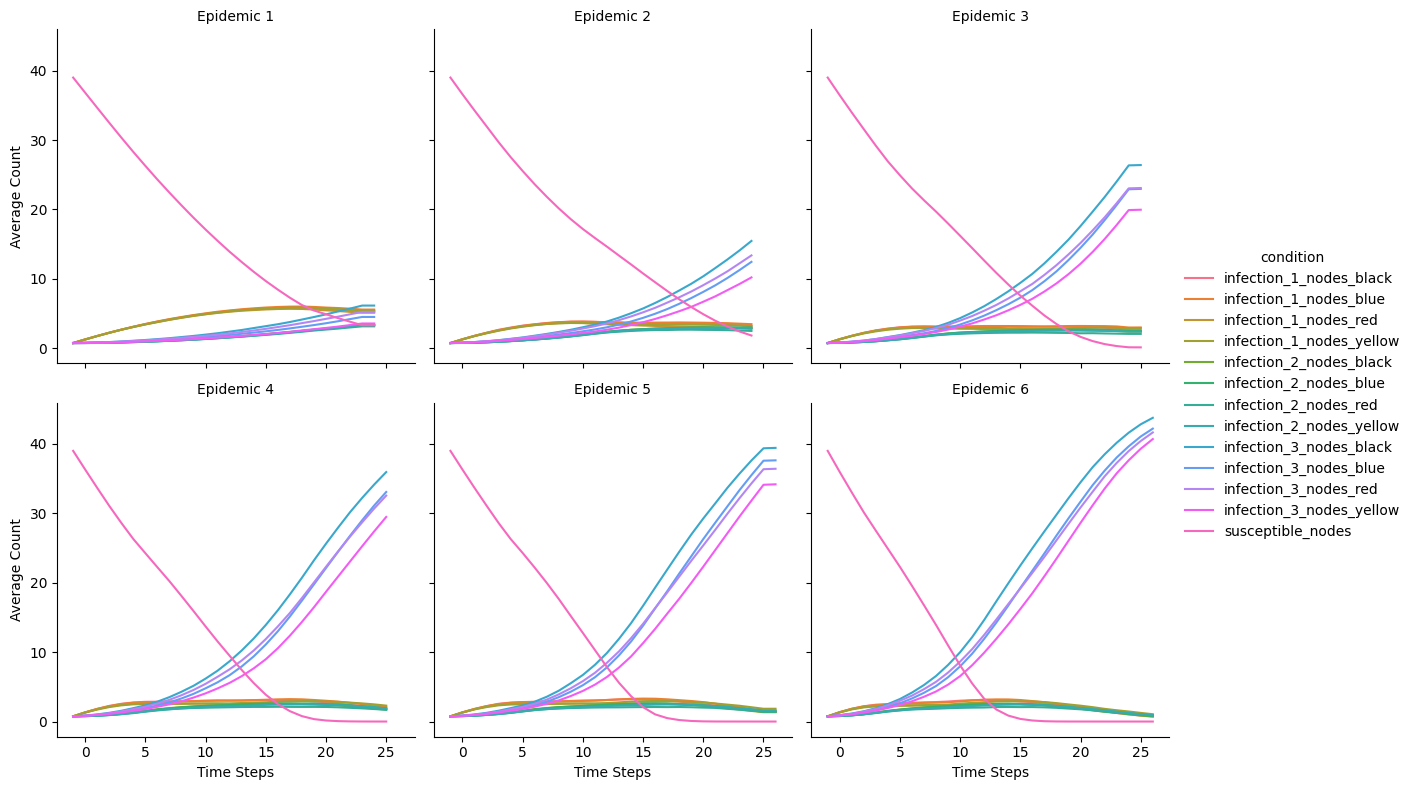

In [4]:
# Load data
df = pd.read_csv('Baseline_4Colors.csv')

# Filter to include only epidemics 1 to 6
df = df[df['no_epidemic'].isin(range(1, 7))]

# Melt the DataFrame to have 'condition' and 'count' columns
df_melted = df.melt(id_vars=['timestep', 'no_epidemic'],
                    value_vars=['susceptible_nodes', 'infection_1_nodes_blue', 'infection_2_nodes_blue', 'infection_3_nodes_blue', 'infection_1_nodes_black', 'infection_2_nodes_black', 'infection_3_nodes_black', 'infection_1_nodes_red', 'infection_2_nodes_red', 'infection_3_nodes_red', 'infection_1_nodes_yellow', 'infection_2_nodes_yellow', 'infection_3_nodes_yellow'],
                    var_name='condition', value_name='count')

# Calculate the mean for each timestep, condition, and no_epidemic
df_mean = df_melted.groupby(['timestep', 'condition', 'no_epidemic'], as_index=False).mean()

# Initialize FacetGrid
g = sns.FacetGrid(df_mean, col='no_epidemic', hue='condition', col_wrap=3, height=4)

# Map the line plot to show average counts over time for each condition
g.map(plt.plot, 'timestep', 'count')

# Set titles for each subplot
g.set_titles('Epidemic {col_name}')

# Add legend to each subplot
g.add_legend()

# Set common labels
g.set_axis_labels('Time Steps','Average Count')

# Show plot
plt.show()


In [7]:
def calculate_avg_timestep_no_susceptible(df):
    # Group by timestep and calculate the mean number of susceptible nodes
    avg_susceptible = df.groupby('timestep')['susceptible_nodes'].mean()

    # Find the first timestep where the average number of susceptible nodes is 0
    avg_timestep_no_susceptible = avg_susceptible[avg_susceptible < 1].index.min()

    return avg_timestep_no_susceptible


#@title Baseline
df = pd.read_csv('Baseline_4Colors.csv')

folder_name = "BaselineStats"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Filter data with no_epidemic equal to 6
filtered_data = df[df['no_epidemic'].isin(epidemic_cards)]

for epidemic_card in epidemic_cards:
    # Filter data for the current epidemic card value
    filtered_data_card = df[df['no_epidemic'] == epidemic_card]

    # Group data by setup (strategy)
    grouped_data = filtered_data_card.groupby('setup')

    avg_timestep_no_susceptible = calculate_avg_timestep_no_susceptible(filtered_data_card)
    print(f"For epidemic card {epidemic_card}, the average timestep when no susceptible nodes are left is {avg_timestep_no_susceptible}")


For epidemic card 0, the average timestep when no susceptible nodes are left is 19
For epidemic card 1, the average timestep when no susceptible nodes are left is nan
For epidemic card 2, the average timestep when no susceptible nodes are left is nan
For epidemic card 3, the average timestep when no susceptible nodes are left is 22
For epidemic card 4, the average timestep when no susceptible nodes are left is 18
For epidemic card 5, the average timestep when no susceptible nodes are left is 17
For epidemic card 6, the average timestep when no susceptible nodes are left is 14


In [8]:
def calculate_avg_timestep_no_susceptible(df):
    # Group by timestep and calculate the mean number of susceptible nodes
    avg_susceptible = df.groupby('timestep')['susceptible_nodes'].mean()

    # Find the first timestep where the average number of susceptible nodes is 0
    avg_timestep_no_susceptible = avg_susceptible[avg_susceptible == 0].index.min()

    return avg_timestep_no_susceptible


#@title Baseline
df = pd.read_csv('Baseline_4Colors.csv')

folder_name = "BaselineStats"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Filter data with no_epidemic equal to 6
filtered_data = df[df['no_epidemic'].isin(epidemic_cards)]

for epidemic_card in epidemic_cards:
    # Filter data for the current epidemic card value
    filtered_data_card = df[df['no_epidemic'] == epidemic_card]

    # Group data by setup (strategy)
    grouped_data = filtered_data_card.groupby('setup')

    avg_timestep_no_susceptible = calculate_avg_timestep_no_susceptible(filtered_data_card)
    print(f"For epidemic card {epidemic_card}, the average timestep when no susceptible nodes are left is {avg_timestep_no_susceptible}")


For epidemic card 0, the average timestep when no susceptible nodes are left is 19
For epidemic card 1, the average timestep when no susceptible nodes are left is nan
For epidemic card 2, the average timestep when no susceptible nodes are left is nan
For epidemic card 3, the average timestep when no susceptible nodes are left is nan
For epidemic card 4, the average timestep when no susceptible nodes are left is nan
For epidemic card 5, the average timestep when no susceptible nodes are left is 24
For epidemic card 6, the average timestep when no susceptible nodes are left is 22


In [ ]:
#@title All other strategies, split the strategy array, because it will break otherwise in Google Colab and run it twice once with the first half and then with the second

strat1 = ["random", "random_repeat", "most_cubes", "most_cubes_repeat",
          "highest_degree", "highest_degree_repeat"]

strat2 = ["combined","combined_repeat", "combined_SUM", "combined_SUM_repeat",
          "combined_MUL", "combined_MUL_repeat"]

strat3 = ["combined_SUM_DC_sum","combined_SUM_DC_sum_repeat", "combined_MUL_DC_sum",
          "combined_MUL_DC_sum_repeat"]

# change the strat1 to strat2 for all strategies after running it once with strat1
for strategy in strat1:
    file_name = f'{strategy}_4Colors.csv'
    df = pd.read_csv(file_name)

    folder_name = f"{strategy}Stats"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for k_action in k_actions_range:
        for epidemic_card in epidemic_cards:
            # Filter data for the current strategy, k_action, and epidemic card value
            filtered_data = df[(df['setup'] == strategy) & (df['k_actions'] == k_action) & (df['no_epidemic'] == epidemic_card)]

            # Group data by setup (strategy)
            grouped_data = filtered_data.groupby('setup')

            for strategy, group_df in grouped_data:
                # Calculate statistics
                avg_susceptible = calculate_avg_susceptible(group_df)

                (avg_infected_1_blue, avg_infected_2_blue, avg_infected_3_blue,
                    avg_infected_1_yellow, avg_infected_2_yellow, avg_infected_3_yellow,
                    avg_infected_1_red, avg_infected_2_red, avg_infected_3_red,
                    avg_infected_1_black, avg_infected_2_black, avg_infected_3_black) = calculate_avg_infected(group_df)

                avg_percentage_infected = calculate_avg_percentage_infected(group_df)
                avg_total_cubes, avg_blue_infection, avg_yellow_infection, avg_red_infection, avg_black_infection = calculate_avg_cubes_and_cube_infection(group_df)
                avg_cubes_per_node = calculate_avg_cubes_per_node(group_df)
                s_percetage = calculate_avg_percentage_susceptible(group_df)

                # Plot statistics
                # Plot Susceptible and Infection Counts Over Time
                plt.figure(figsize=(12, 8))
                colors = {
                    'Blue': ['#add8e6', '#0000FF', '#00008B'],
                    'Yellow': ['#ffffe0', '#ffff00', '#808000'],
                    'Red': ['#ffcccb', '#ff0000', '#8b0000'],
                    'Black': ['#d3d3d3', '#808080', '#000000']
                }

                plt.plot(avg_susceptible.index, avg_susceptible.values, label='Susceptible', color='green')
                for color_name, shades in colors.items():
                    for i, shade in enumerate(shades):
                        avg_infected = globals()[f'avg_infected_{i+1}_{color_name.lower()}']
                        plt.plot(avg_infected.index, avg_infected.values, label=f'{color_name} ({i+1} cube)', color=shade)

                plt.xlabel('Time Steps')
                plt.ylabel('Count')
                plt.title(f'{strategy} - K Action {k_action} - Epidemic {epidemic_card}: Susceptible and Infection Counts Over Time')
                plt.legend()
                plt.savefig(os.path.join(folder_name, f'{strategy}_K_{k_action}_Epidemi_{epidemic_card}_susceptible_and_infection_counts.png'))
                plt.show()
                plt.close()

                # Plot Percentage of Infected Nodes over time steps
                plt.figure(figsize=(12, 8))
                plt.plot(avg_percentage_infected.index, avg_percentage_infected.values, label='Percentage of Infected Nodes')
                plt.plot(s_percetage.index, s_percetage.values, label='Percentage of Susceptible Nodes')
                plt.xlabel('Time Steps')
                plt.ylabel('Percentage')
                plt.title(f'{strategy} - K Action {k_action} - Epidemic {epidemic_card}: Percentage of Infected Nodes Over Time')
                plt.legend()
                plt.savefig(os.path.join(folder_name, f'{strategy}_K_{k_action}_Epidemi_{epidemic_card}_percentage_of_infected_nodes.png')) # Save the plot
                plt.show()
                plt.close()

                # Plot Total Cubes and Cube Infection counts over time steps
                plt.figure(figsize=(12, 8))
                plt.plot(avg_total_cubes.index, avg_total_cubes.values, label='Total Cubes', color='magenta')

                plt.plot(avg_blue_infection.index, avg_blue_infection.values, label='Blue Infection Counts',color='blue')
                plt.plot(avg_yellow_infection.index, avg_yellow_infection.values, label='Yellow Infection Counts',color='yellow')
                plt.plot(avg_red_infection.index, avg_red_infection.values, label='Red Infection Counts',color='red')
                plt.plot(avg_black_infection.index, avg_black_infection.values, label='Black Infection Counts',color='black')

                plt.xlabel('Time Steps')
                plt.ylabel('Count')
                plt.title(f'{strategy} - K Action {k_action} - Epidemic {epidemic_card}: Total Cubes and Blue Infection Counts Over Time')
                plt.legend()
                plt.savefig(os.path.join(folder_name, f'{strategy}_K_{k_action}_Epidemi_{epidemic_card}_total_cubes_and_blue_infection_counts.png'))
                plt.show()
                plt.close()

                # Plot Avg Cubes per Node over time steps
                plt.figure(figsize=(12, 8))
                plt.plot(avg_cubes_per_node.index, avg_cubes_per_node.values, label='Avg Cubes per Node')
                plt.xlabel('Time Steps')
                plt.ylabel('Average Cubes per Node')
                plt.title(f'{strategy} - K Action {k_action} - Epidemic {epidemic_card}: Avg Cubes per Node Over Time')
                plt.legend()
                plt.savefig(os.path.join(folder_name, f'{strategy}_K_{k_action}_Epidemi_{epidemic_card}_avg_cubes_per_node.png'))
                plt.show()
                plt.close()

In [ ]:
#@title All other strategies, split the strategy array, because it will break otherwise in Google Colab and run it twice once with the first half and then with the second

strat1 = ["random", "random_repeat", "most_cubes", "most_cubes_repeat",
          "highest_degree", "highest_degree_repeat"]

strat2 = ["combined","combined_repeat", "combined_SUM", "combined_SUM_repeat",
          "combined_MUL", "combined_MUL_repeat"]

strat3 = ["combined_SUM_DC_sum","combined_SUM_DC_sum_repeat", "combined_MUL_DC_sum",
          "combined_MUL_DC_sum_repeat"]

# change the strat1 to strat2 for all strategies after running it once with strat1
for strategy in strat2:
    file_name = f'{strategy}_4Colors.csv'
    df = pd.read_csv(file_name)

    folder_name = f"{strategy}Stats"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for k_action in k_actions_range:
        for epidemic_card in epidemic_cards:
            # Filter data for the current strategy, k_action, and epidemic card value
            filtered_data = df[(df['setup'] == strategy) & (df['k_actions'] == k_action) & (df['no_epidemic'] == epidemic_card)]

            # Group data by setup (strategy)
            grouped_data = filtered_data.groupby('setup')

            for strategy, group_df in grouped_data:
                # Calculate statistics
                avg_susceptible = calculate_avg_susceptible(group_df)

                (avg_infected_1_blue, avg_infected_2_blue, avg_infected_3_blue,
                    avg_infected_1_yellow, avg_infected_2_yellow, avg_infected_3_yellow,
                    avg_infected_1_red, avg_infected_2_red, avg_infected_3_red,
                    avg_infected_1_black, avg_infected_2_black, avg_infected_3_black) = calculate_avg_infected(group_df)

                avg_percentage_infected = calculate_avg_percentage_infected(group_df)
                avg_total_cubes, avg_blue_infection, avg_yellow_infection, avg_red_infection, avg_black_infection = calculate_avg_cubes_and_cube_infection(group_df)
                avg_cubes_per_node = calculate_avg_cubes_per_node(group_df)
                s_percetage = calculate_avg_percentage_susceptible(group_df)

                # Plot statistics
                # Plot Susceptible and Infection Counts Over Time
                plt.figure(figsize=(12, 8))
                colors = {
                    'Blue': ['#add8e6', '#0000FF', '#00008B'],
                    'Yellow': ['#ffffe0', '#ffff00', '#808000'],
                    'Red': ['#ffcccb', '#ff0000', '#8b0000'],
                    'Black': ['#d3d3d3', '#808080', '#000000']
                }

                plt.plot(avg_susceptible.index, avg_susceptible.values, label='Susceptible', color='green')
                for color_name, shades in colors.items():
                    for i, shade in enumerate(shades):
                        avg_infected = globals()[f'avg_infected_{i+1}_{color_name.lower()}']
                        plt.plot(avg_infected.index, avg_infected.values, label=f'{color_name} ({i+1} cube)', color=shade)

                plt.xlabel('Time Steps')
                plt.ylabel('Count')
                plt.title(f'{strategy} - K Action {k_action} - Epidemic {epidemic_card}: Susceptible and Infection Counts Over Time')
                plt.legend()
                plt.savefig(os.path.join(folder_name, f'{strategy}_K_{k_action}_Epidemi_{epidemic_card}_susceptible_and_infection_counts.png'))
                plt.show()
                plt.close()

                # Plot Percentage of Infected Nodes over time steps
                plt.figure(figsize=(12, 8))
                plt.plot(avg_percentage_infected.index, avg_percentage_infected.values, label='Percentage of Infected Nodes')
                plt.plot(s_percetage.index, s_percetage.values, label='Percentage of Susceptible Nodes')
                plt.xlabel('Time Steps')
                plt.ylabel('Percentage')
                plt.title(f'{strategy} - K Action {k_action} - Epidemic {epidemic_card}: Percentage of Infected Nodes Over Time')
                plt.legend()
                plt.savefig(os.path.join(folder_name, f'{strategy}_K_{k_action}_Epidemi_{epidemic_card}_percentage_of_infected_nodes.png')) # Save the plot
                plt.show()
                plt.close()

                # Plot Total Cubes and Cube Infection counts over time steps
                plt.figure(figsize=(12, 8))
                plt.plot(avg_total_cubes.index, avg_total_cubes.values, label='Total Cubes', color='magenta')

                plt.plot(avg_blue_infection.index, avg_blue_infection.values, label='Blue Infection Counts',color='blue')
                plt.plot(avg_yellow_infection.index, avg_yellow_infection.values, label='Yellow Infection Counts',color='yellow')
                plt.plot(avg_red_infection.index, avg_red_infection.values, label='Red Infection Counts',color='red')
                plt.plot(avg_black_infection.index, avg_black_infection.values, label='Black Infection Counts',color='black')

                plt.xlabel('Time Steps')
                plt.ylabel('Count')
                plt.title(f'{strategy} - K Action {k_action} - Epidemic {epidemic_card}: Total Cubes and Blue Infection Counts Over Time')
                plt.legend()
                plt.savefig(os.path.join(folder_name, f'{strategy}_K_{k_action}_Epidemi_{epidemic_card}_total_cubes_and_blue_infection_counts.png'))
                plt.show()
                plt.close()

                # Plot Avg Cubes per Node over time steps
                plt.figure(figsize=(12, 8))
                plt.plot(avg_cubes_per_node.index, avg_cubes_per_node.values, label='Avg Cubes per Node')
                plt.xlabel('Time Steps')
                plt.ylabel('Average Cubes per Node')
                plt.title(f'{strategy} - K Action {k_action} - Epidemic {epidemic_card}: Avg Cubes per Node Over Time')
                plt.legend()
                plt.savefig(os.path.join(folder_name, f'{strategy}_K_{k_action}_Epidemi_{epidemic_card}_avg_cubes_per_node.png'))
                plt.show()
                plt.close()

In [ ]:
#@title All other strategies, split the strategy array, because it will break otherwise in Google Colab and run it twice once with the first half and then with the second

strat1 = ["random", "random_repeat", "most_cubes", "most_cubes_repeat",
          "highest_degree", "highest_degree_repeat"]

strat2 = ["combined","combined_repeat", "combined_SUM", "combined_SUM_repeat",
          "combined_MUL", "combined_MUL_repeat"]

strat3 = ["combined_SUM_DC_sum","combined_SUM_DC_sum_repeat", "combined_MUL_DC_sum",
          "combined_MUL_DC_sum_repeat"]

# change the strat1 to strat2 for all strategies after running it once with strat1
for strategy in strat3:
    file_name = f'{strategy}_4Colors.csv'
    df = pd.read_csv(file_name)

    folder_name = f"{strategy}Stats"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for k_action in k_actions_range:
        for epidemic_card in epidemic_cards:
            # Filter data for the current strategy, k_action, and epidemic card value
            filtered_data = df[(df['setup'] == strategy) & (df['k_actions'] == k_action) & (df['no_epidemic'] == epidemic_card)]

            # Group data by setup (strategy)
            grouped_data = filtered_data.groupby('setup')

            for strategy, group_df in grouped_data:
                # Calculate statistics
                avg_susceptible = calculate_avg_susceptible(group_df)

                (avg_infected_1_blue, avg_infected_2_blue, avg_infected_3_blue,
                    avg_infected_1_yellow, avg_infected_2_yellow, avg_infected_3_yellow,
                    avg_infected_1_red, avg_infected_2_red, avg_infected_3_red,
                    avg_infected_1_black, avg_infected_2_black, avg_infected_3_black) = calculate_avg_infected(group_df)

                avg_percentage_infected = calculate_avg_percentage_infected(group_df)
                avg_total_cubes, avg_blue_infection, avg_yellow_infection, avg_red_infection, avg_black_infection = calculate_avg_cubes_and_cube_infection(group_df)
                avg_cubes_per_node = calculate_avg_cubes_per_node(group_df)
                s_percetage = calculate_avg_percentage_susceptible(group_df)

                # Plot statistics
                # Plot Susceptible and Infection Counts Over Time
                plt.figure(figsize=(12, 8))
                colors = {
                    'Blue': ['#add8e6', '#0000FF', '#00008B'],
                    'Yellow': ['#ffffe0', '#ffff00', '#808000'],
                    'Red': ['#ffcccb', '#ff0000', '#8b0000'],
                    'Black': ['#d3d3d3', '#808080', '#000000']
                }

                plt.plot(avg_susceptible.index, avg_susceptible.values, label='Susceptible', color='green')
                for color_name, shades in colors.items():
                    for i, shade in enumerate(shades):
                        avg_infected = globals()[f'avg_infected_{i+1}_{color_name.lower()}']
                        plt.plot(avg_infected.index, avg_infected.values, label=f'{color_name} ({i+1} cube)', color=shade)

                plt.xlabel('Time Steps')
                plt.ylabel('Count')
                plt.title(f'{strategy} - K Action {k_action} - Epidemic {epidemic_card}: Susceptible and Infection Counts Over Time')
                plt.legend()
                plt.savefig(os.path.join(folder_name, f'{strategy}_K_{k_action}_Epidemi_{epidemic_card}_susceptible_and_infection_counts.png'))
                plt.show()
                plt.close()

                # Plot Percentage of Infected Nodes over time steps
                plt.figure(figsize=(12, 8))
                plt.plot(avg_percentage_infected.index, avg_percentage_infected.values, label='Percentage of Infected Nodes')
                plt.plot(s_percetage.index, s_percetage.values, label='Percentage of Susceptible Nodes')
                plt.xlabel('Time Steps')
                plt.ylabel('Percentage')
                plt.title(f'{strategy} - K Action {k_action} - Epidemic {epidemic_card}: Percentage of Infected Nodes Over Time')
                plt.legend()
                plt.savefig(os.path.join(folder_name, f'{strategy}_K_{k_action}_Epidemi_{epidemic_card}_percentage_of_infected_nodes.png')) # Save the plot
                plt.show()
                plt.close()

                # Plot Total Cubes and Cube Infection counts over time steps
                plt.figure(figsize=(12, 8))
                plt.plot(avg_total_cubes.index, avg_total_cubes.values, label='Total Cubes', color='magenta')

                plt.plot(avg_blue_infection.index, avg_blue_infection.values, label='Blue Infection Counts',color='blue')
                plt.plot(avg_yellow_infection.index, avg_yellow_infection.values, label='Yellow Infection Counts',color='yellow')
                plt.plot(avg_red_infection.index, avg_red_infection.values, label='Red Infection Counts',color='red')
                plt.plot(avg_black_infection.index, avg_black_infection.values, label='Black Infection Counts',color='black')

                plt.xlabel('Time Steps')
                plt.ylabel('Count')
                plt.title(f'{strategy} - K Action {k_action} - Epidemic {epidemic_card}: Total Cubes and Blue Infection Counts Over Time')
                plt.legend()
                plt.savefig(os.path.join(folder_name, f'{strategy}_K_{k_action}_Epidemi_{epidemic_card}_total_cubes_and_blue_infection_counts.png'))
                plt.show()
                plt.close()

                # Plot Avg Cubes per Node over time steps
                plt.figure(figsize=(12, 8))
                plt.plot(avg_cubes_per_node.index, avg_cubes_per_node.values, label='Avg Cubes per Node')
                plt.xlabel('Time Steps')
                plt.ylabel('Average Cubes per Node')
                plt.title(f'{strategy} - K Action {k_action} - Epidemic {epidemic_card}: Avg Cubes per Node Over Time')
                plt.legend()
                plt.savefig(os.path.join(folder_name, f'{strategy}_K_{k_action}_Epidemi_{epidemic_card}_avg_cubes_per_node.png'))
                plt.show()
                plt.close()

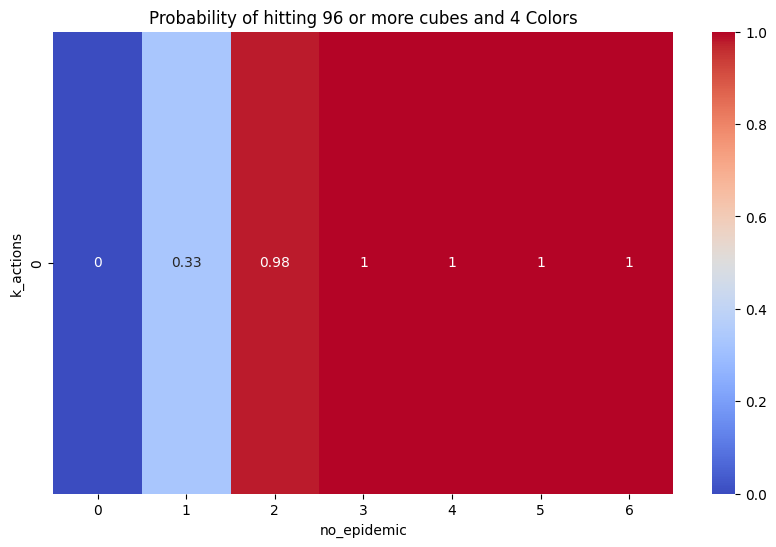

In [ ]:
#@title Baseline lose condition heatmap

baseline_df = pd.read_csv('Baseline_4Colors.csv')

# Initialize a 2D array to store probabilities
# 0 Actions for baseline
probabilities = np.zeros((len([0]), len(epidemic_cards)))  # Swapping dimensions

# Iterate over all combinations of 'no_epidemic' and 'k_actions'
for i, no_epi in enumerate(epidemic_cards):
    for j, k_act in enumerate([0]):  # Adjusted indices
        # Filter the DataFrame based on the current combination
        filtered_df = baseline_df[(baseline_df['no_epidemic'] == no_epi) & (baseline_df['k_actions'] == k_act)]

        # Initialize counter for this combination
        count = 0

        # Iterate over each run in the filtered DataFrame
        for _, run in filtered_df.groupby('run'):
            # Calculate the total number of cubes for each timestep in the run
            total_cubes_per_timestep = (run['infection_1_nodes_blue'] + 2 * run['infection_2_nodes_blue'] + 3 * run['infection_3_nodes_blue'] +
                                        run['infection_1_nodes_yellow'] + 2 * run['infection_2_nodes_yellow'] + 3 * run['infection_3_nodes_yellow'] +
                                        run['infection_1_nodes_red'] + 2 * run['infection_2_nodes_red'] + 3 * run['infection_3_nodes_red'] +
                                        run['infection_1_nodes_black'] + 2 * run['infection_2_nodes_black'] + 3 * run['infection_3_nodes_black'])
            # Check if any timestep within the run has 96 or more cubes
            if (total_cubes_per_timestep >= 96).any():
                count += 1

        # Calculate the probability
        probability = count / 10000

        # Store the probability in the 2D array
        probabilities[j, i] = probability

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(probabilities, cmap='coolwarm', annot=True, xticklabels=epidemic_cards, yticklabels=[0])
plt.xlabel('no_epidemic')
plt.ylabel('k_actions')
plt.title('Probability of hitting 96 or more cubes and 4 Colors')
plt.savefig((f'Baseline_4Colors_Probability_of_hitting_96_or_more_cubes.png'))
plt.show()

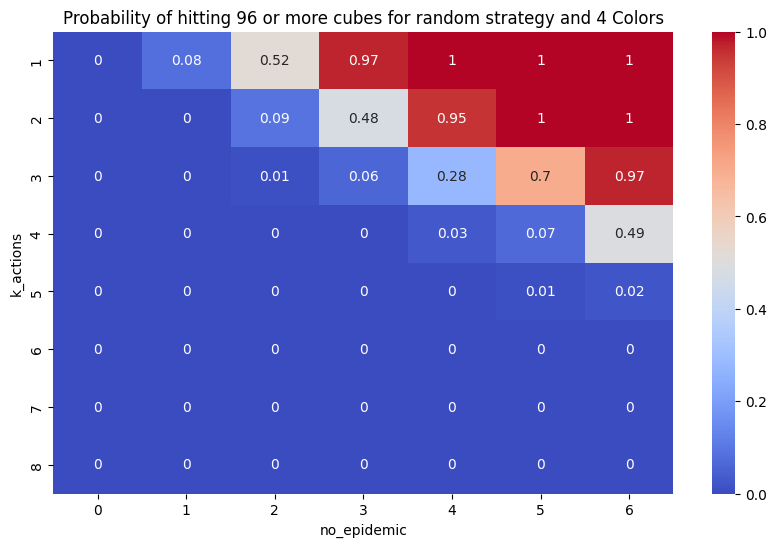

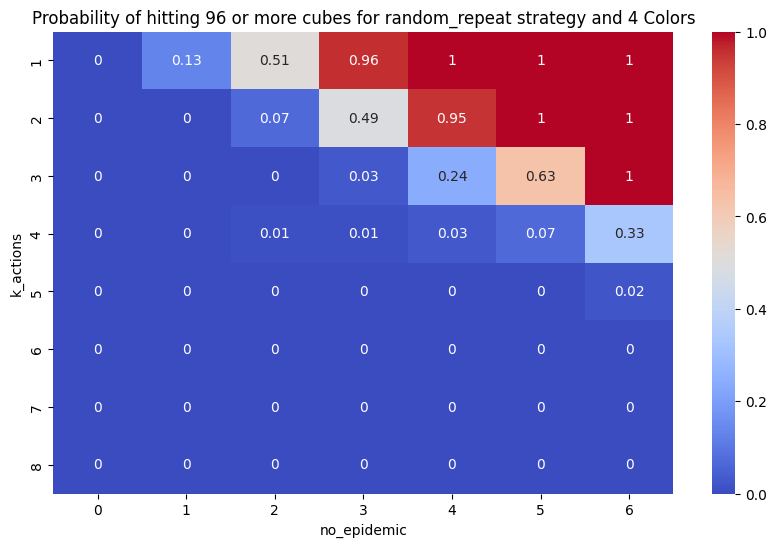

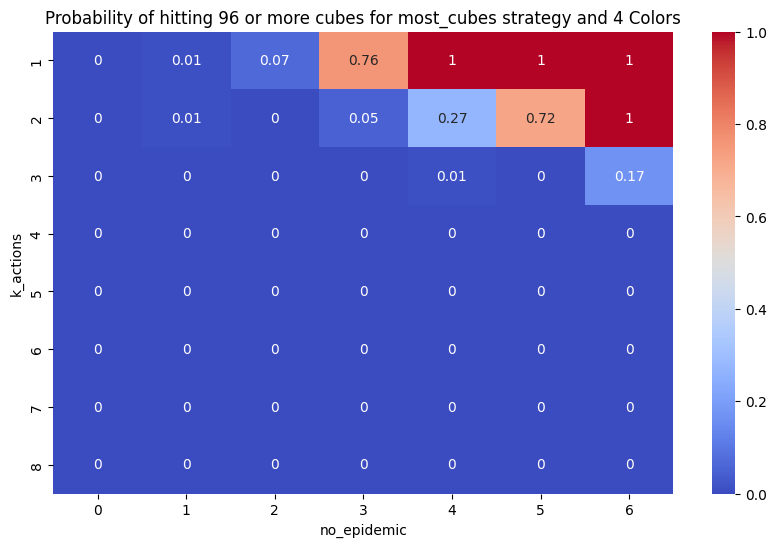

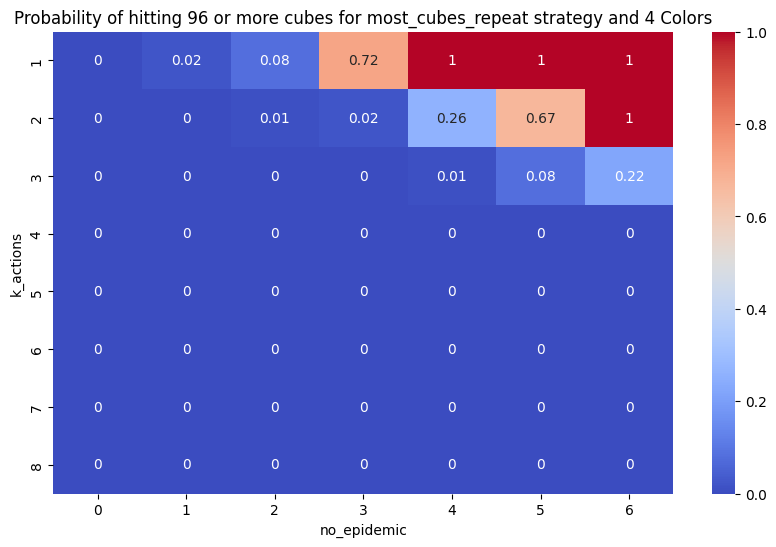

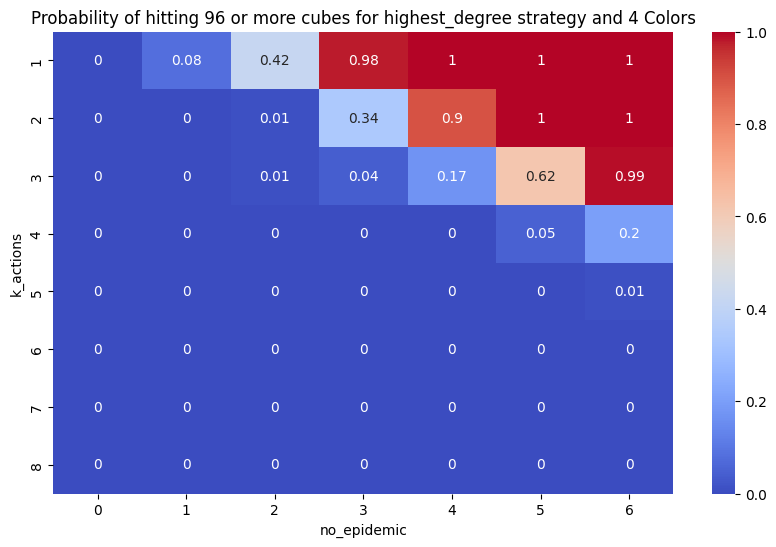

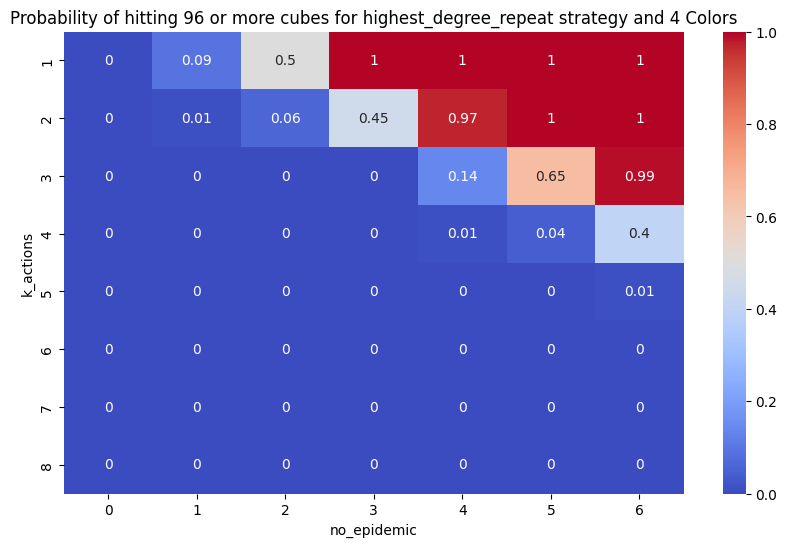

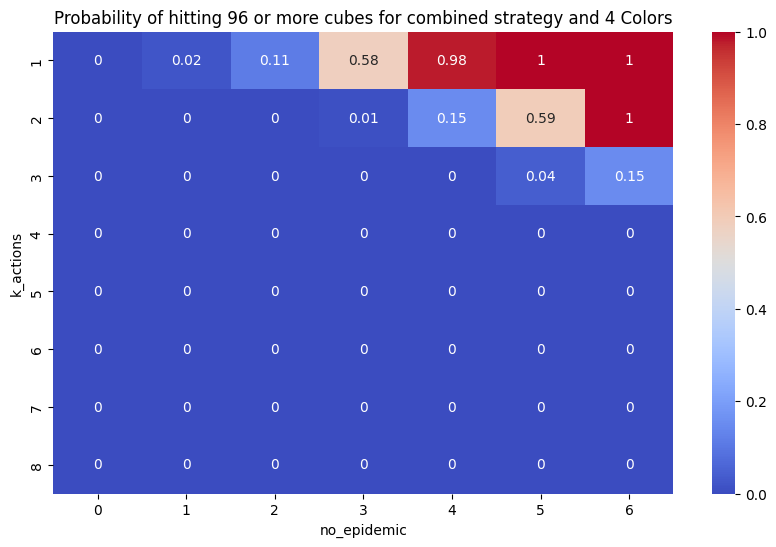

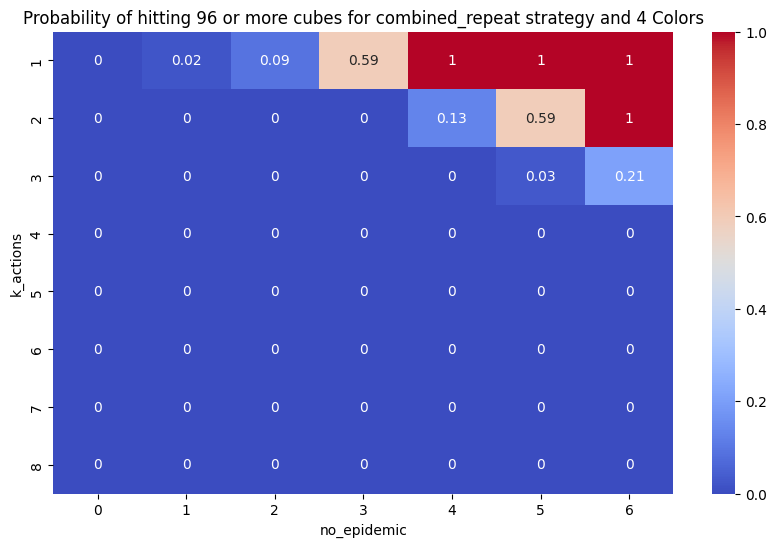

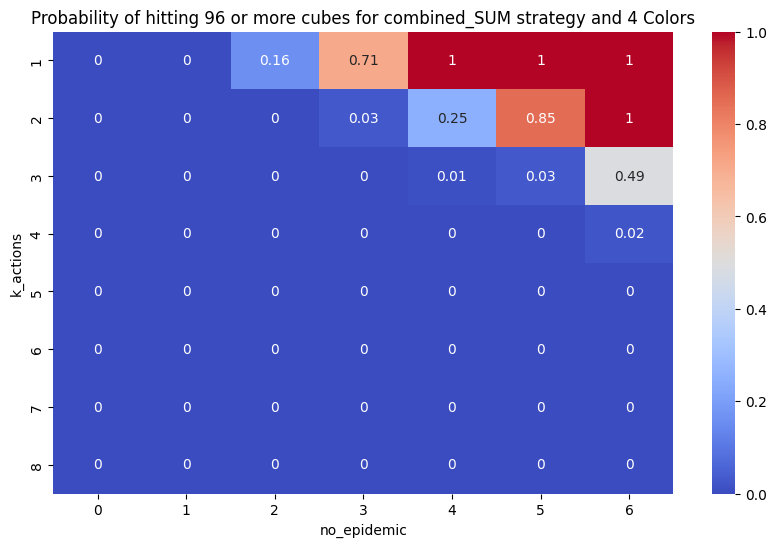

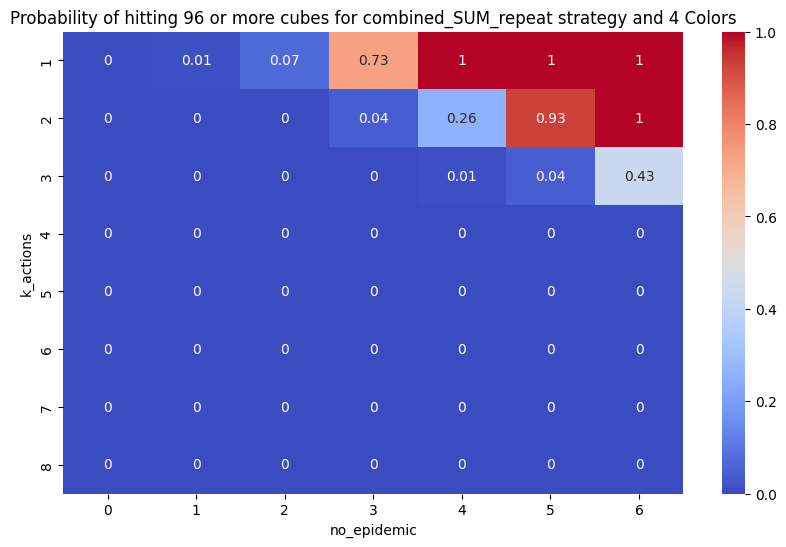

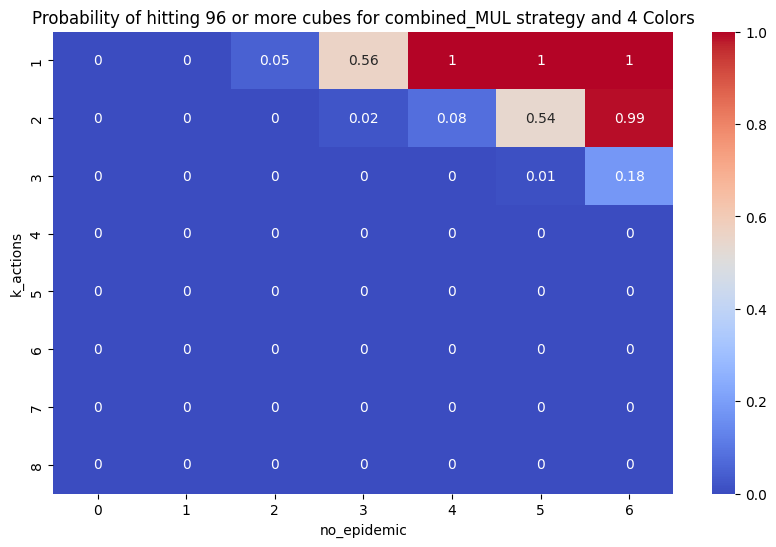

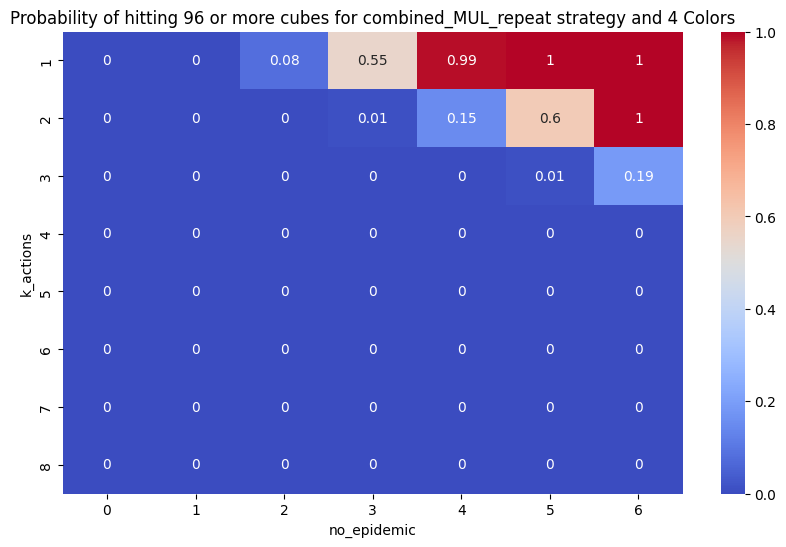

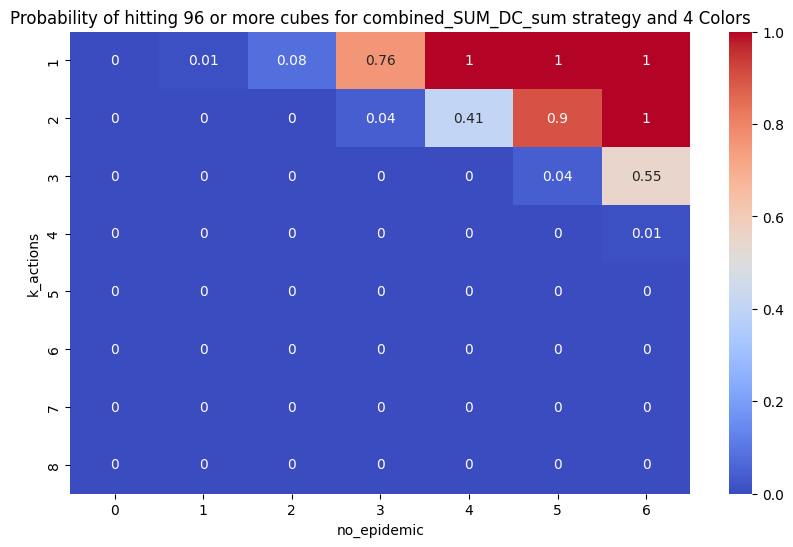

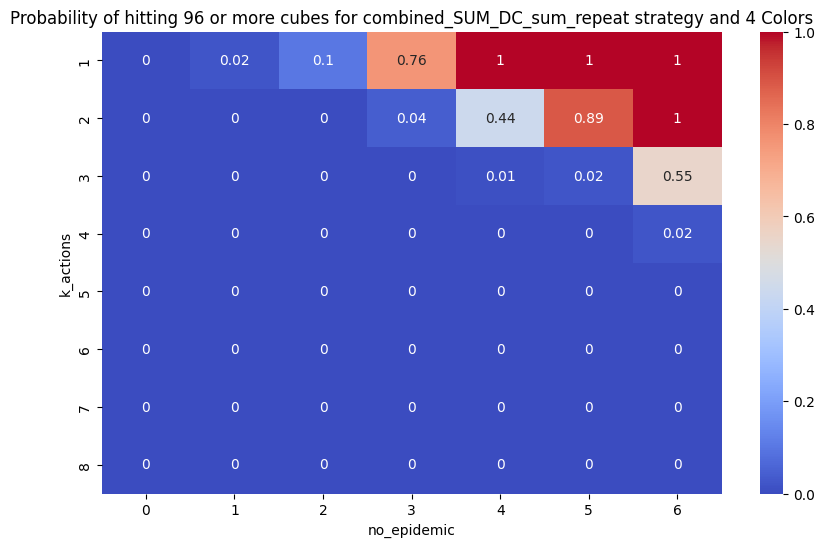

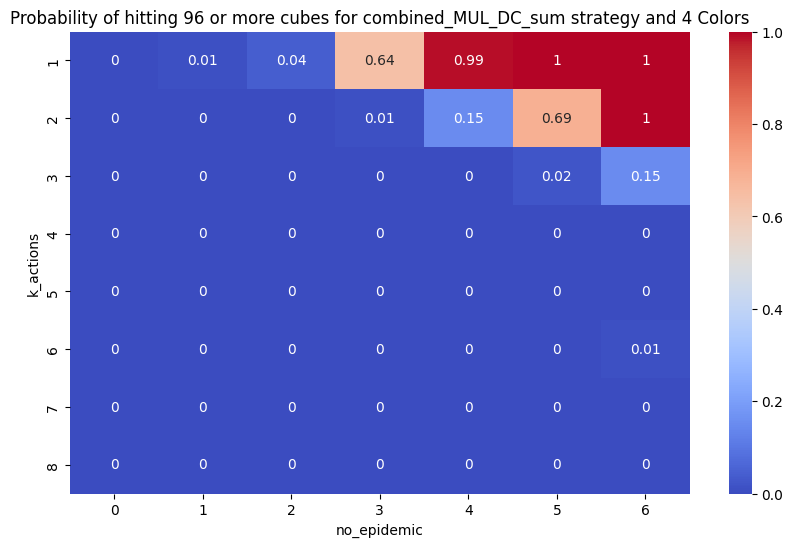

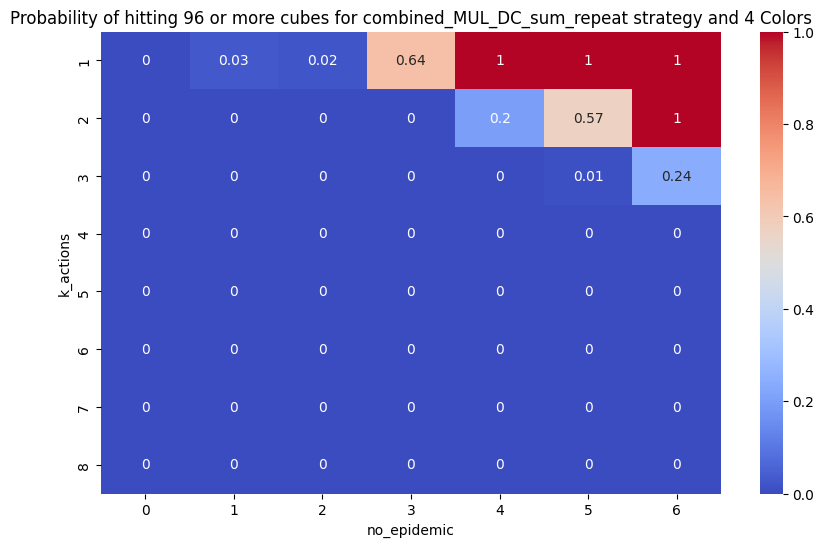

In [ ]:
#@title All strategies lose condition heatmap

for strategy in strategies:
    strategy_df = pd.read_csv(f'{strategy}_4Colors.csv')

    unique_k_actions = sorted(strategy_df['k_actions'].unique())

    # Initialize a 2D array to store probabilities
    probabilities = np.zeros((len(unique_k_actions), len(epidemic_cards)))

    # Iterate over all combinations of 'no_epidemic' and 'k_actions'
    for i, no_epi in enumerate(epidemic_cards):
        for j, k_act in enumerate(unique_k_actions):
            # Filter the DataFrame based on the current combination
            filtered_df = strategy_df[(strategy_df['no_epidemic'] == no_epi) & (strategy_df['k_actions'] == k_act)]

            # Initialize counter for this combination
            count = 0

            # Iterate over each run in the filtered DataFrame
            for _, run in filtered_df.groupby('run'):
                # Calculate the total number of cubes for each timestep in the run
                total_cubes_per_timestep = (run['infection_1_nodes_blue'] + 2 * run['infection_2_nodes_blue'] + 3 * run['infection_3_nodes_blue'] +
                                            run['infection_1_nodes_yellow'] + 2 * run['infection_2_nodes_yellow'] + 3 * run['infection_3_nodes_yellow'] +
                                            run['infection_1_nodes_red'] + 2 * run['infection_2_nodes_red'] + 3 * run['infection_3_nodes_red'] +
                                            run['infection_1_nodes_black'] + 2 * run['infection_2_nodes_black'] + 3 * run['infection_3_nodes_black'])
                # Check if any timestep within the run has 96 or more cubes
                if (total_cubes_per_timestep >= 96).any():
                    count += 1

            # Calculate the probability
            probability = count / 10000

            # Store the probability in the 2D array
            probabilities[j, i] = probability

    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(probabilities, cmap='coolwarm', annot=True, xticklabels=epidemic_cards, yticklabels=unique_k_actions)
    plt.xlabel('no_epidemic')
    plt.ylabel('k_actions')
    plt.title(f'Probability of hitting 96 or more cubes for {strategy} strategy and 4 Colors')
    plt.savefig((f'{strategy}_4Colors_Probability_of_hitting_96_or_more_cubes.png'))
    plt.show()

In [ ]:
#@title 96 Cubes lose condition boxplot
def calculate_96_cube_boxplot(df, setup_name):

    # Define the unique values of 'no_epidemic' and 'k_actions'
    unique_no_epidemics = sorted(df['no_epidemic'].unique())
    unique_k_actions = sorted(df['k_actions'].unique())

    # Initialize an empty list to store timestep data
    timestep_data = []

    # Iterate over all combinations of 'no_epidemic' and 'k_actions'
    for no_epi in unique_no_epidemics:
        for k_act in unique_k_actions:
            # Filter the DataFrame based on the current combination
            filtered_df = df[(df['no_epidemic'] == no_epi) & (df['k_actions'] == k_act)]

            # Iterate over each run in the filtered DataFrame
            for _, run in filtered_df.groupby('run'):
                # Calculate the total number of cubes for each timestep in the run
                total_cubes_per_timestep = (run['infection_1_nodes_blue'] + 2 * run['infection_2_nodes_blue'] + 3 * run['infection_3_nodes_blue'] +
                                            run['infection_1_nodes_yellow'] + 2 * run['infection_2_nodes_yellow'] + 3 * run['infection_3_nodes_yellow'] +
                                            run['infection_1_nodes_red'] + 2 * run['infection_2_nodes_red'] + 3 * run['infection_3_nodes_red'] +
                                            run['infection_1_nodes_black'] + 2 * run['infection_2_nodes_black'] + 3 * run['infection_3_nodes_black'])
                # Check if any timestep within the run has 96 or more cubes
                if (total_cubes_per_timestep >= 96).any():
                    # Get the timestep where the condition is met
                    timestep = run.loc[total_cubes_per_timestep >= 96, 'timestep'].iloc[0]
                    timestep_data.append({'no_epidemic': no_epi, 'k_actions': k_act, 'timestep': timestep})

    # Create a DataFrame from the timestep data
    timestep_df = pd.DataFrame(timestep_data)

    # Create the box plot
    num_colors = len(timestep_df['k_actions'].unique())
    palette = sns.color_palette("husl", num_colors)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=timestep_df, x='no_epidemic', y='timestep', hue='k_actions', palette=palette)
    plt.xlabel('no_epidemic')
    plt.ylabel('Timestep when 96 cubes were reached')
    plt.title(f'Timestep of hitting 96 or more cubes for {setup_name} setup and 4 Colors')
    plt.savefig((f'{setup_name}_4Colors_Boxplot_96_or_more_cubes.png'))
    plt.show()

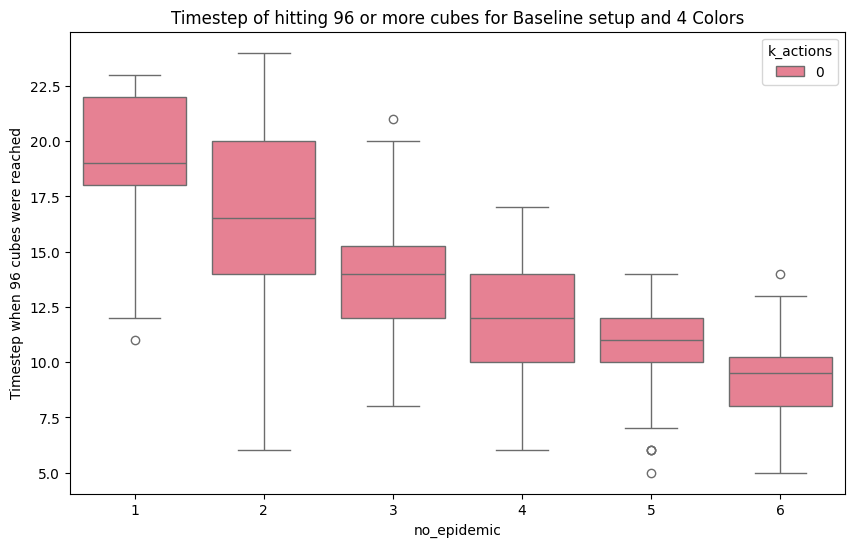

In [ ]:
baseline_df = pd.read_csv('Baseline_4Colors.csv')

# Define the setup name
setup_name = "Baseline"

# Call the function with your baseline_df and setup_name
calculate_96_cube_boxplot(baseline_df, setup_name)

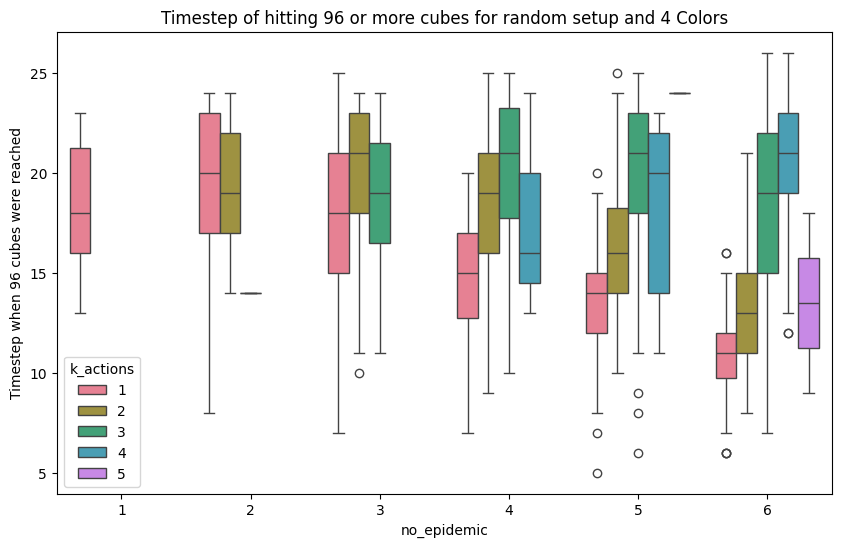

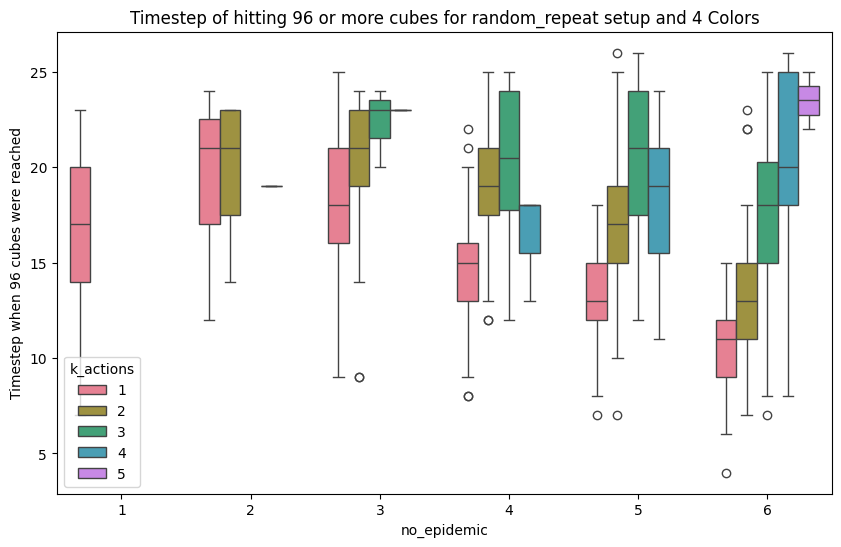

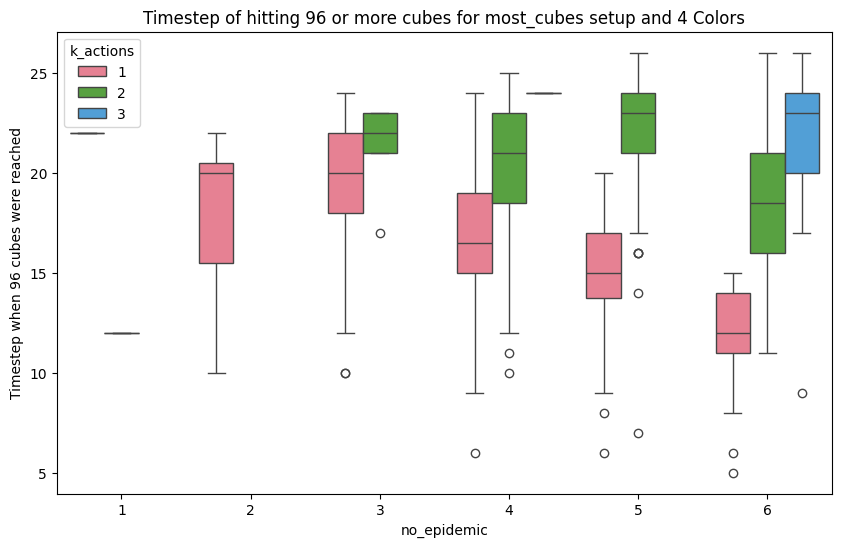

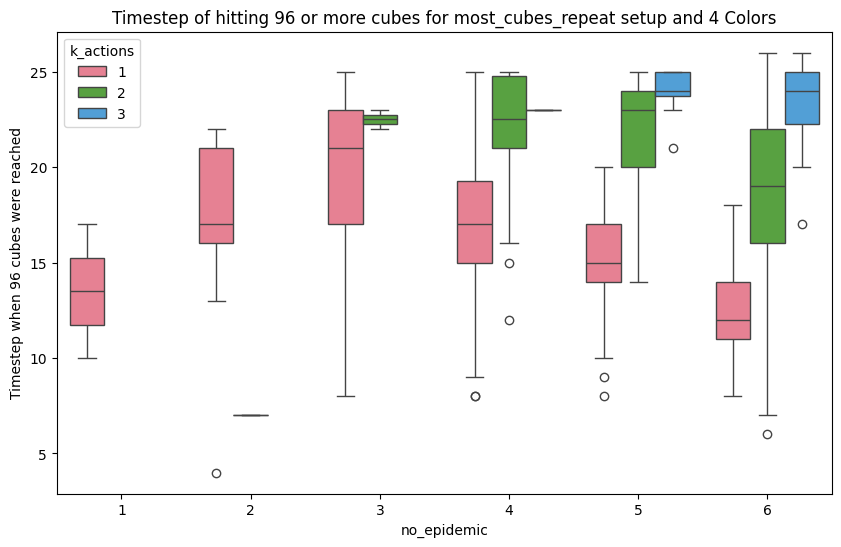

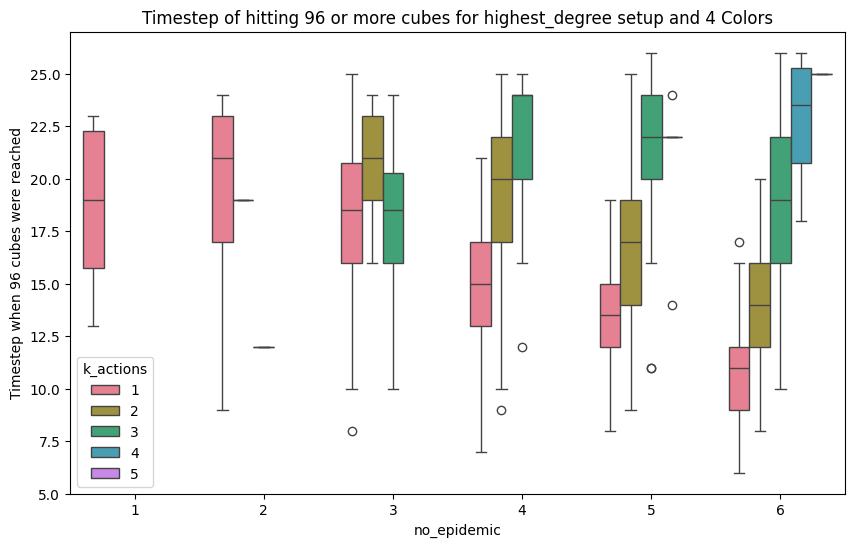

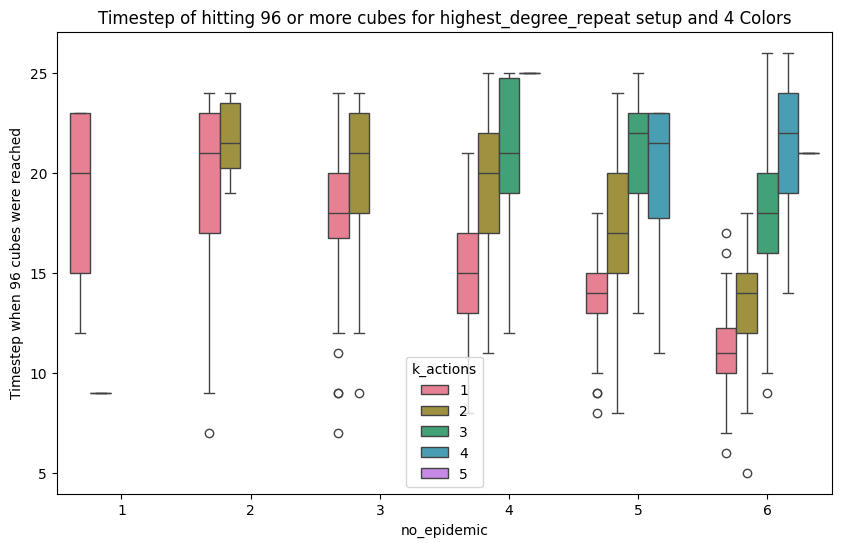

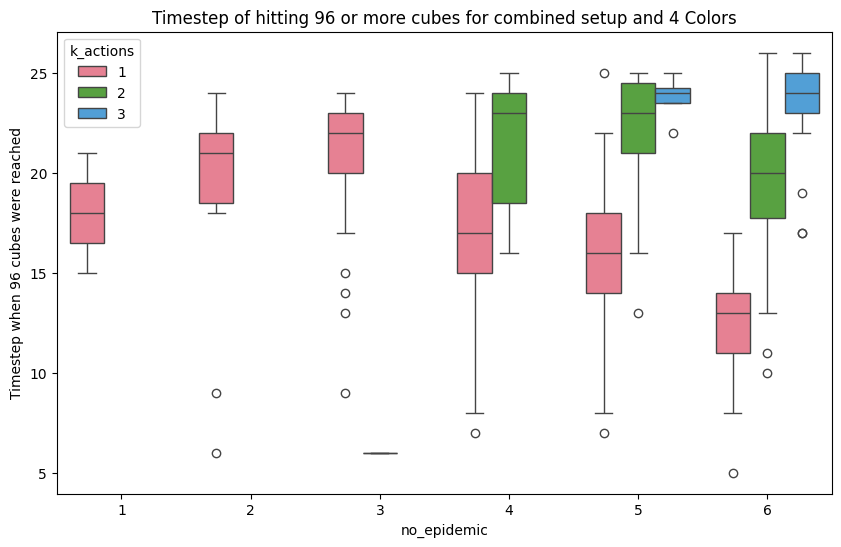

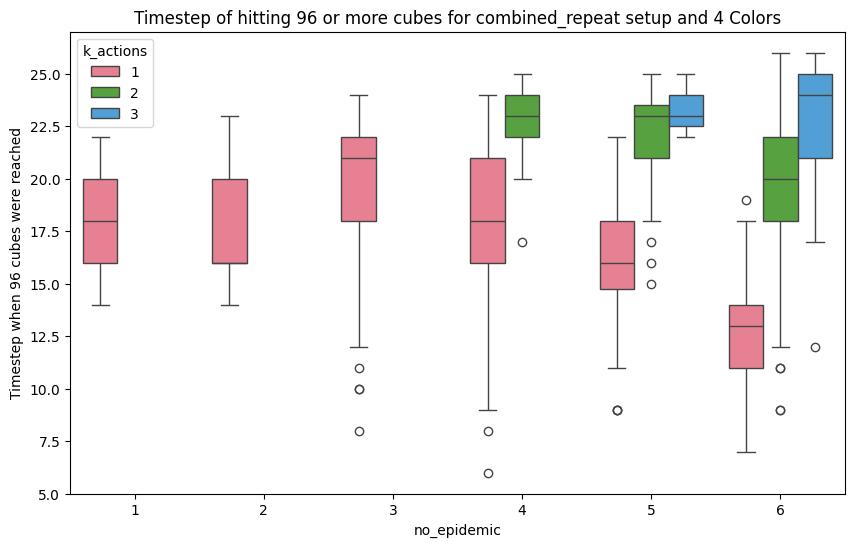

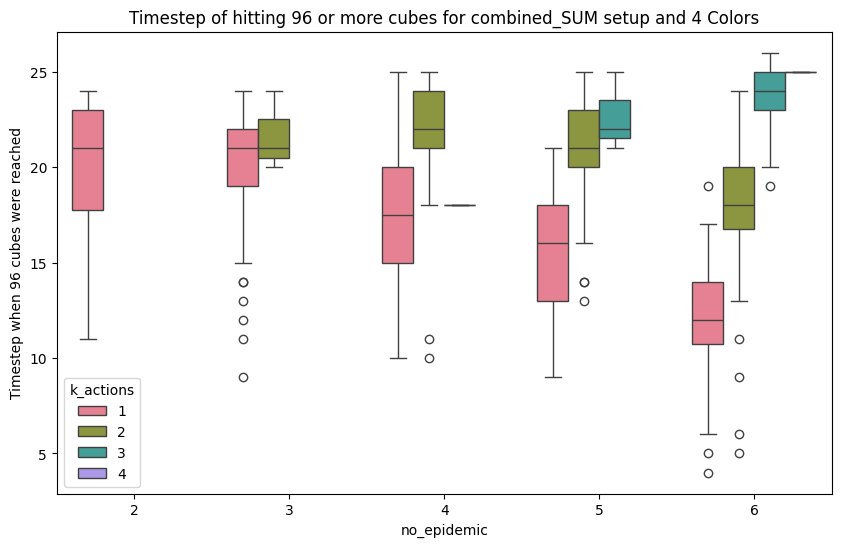

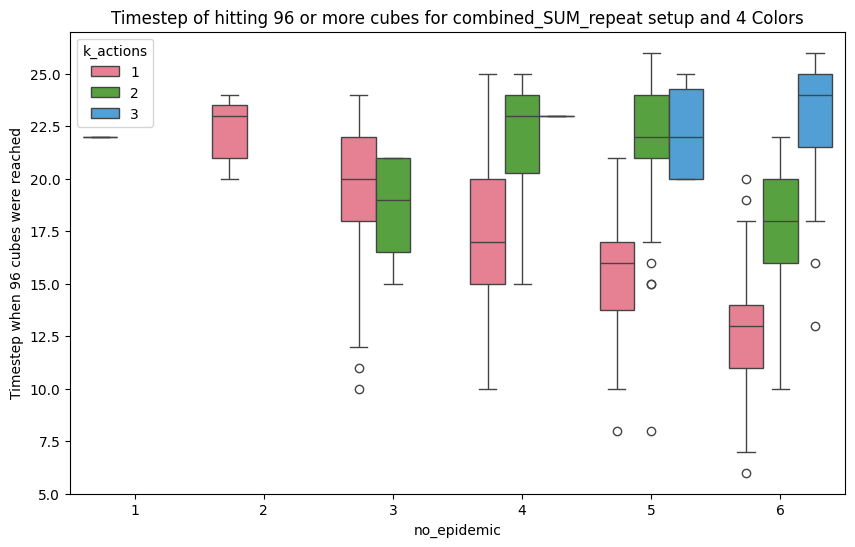

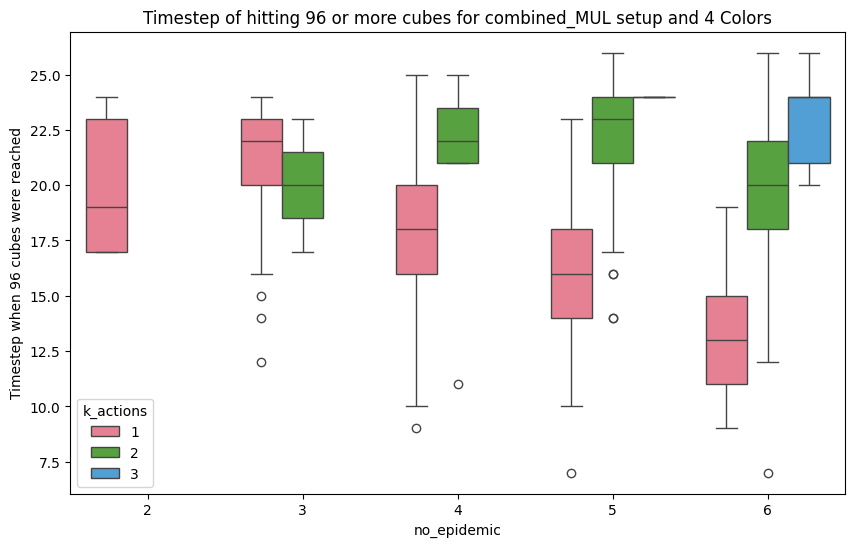

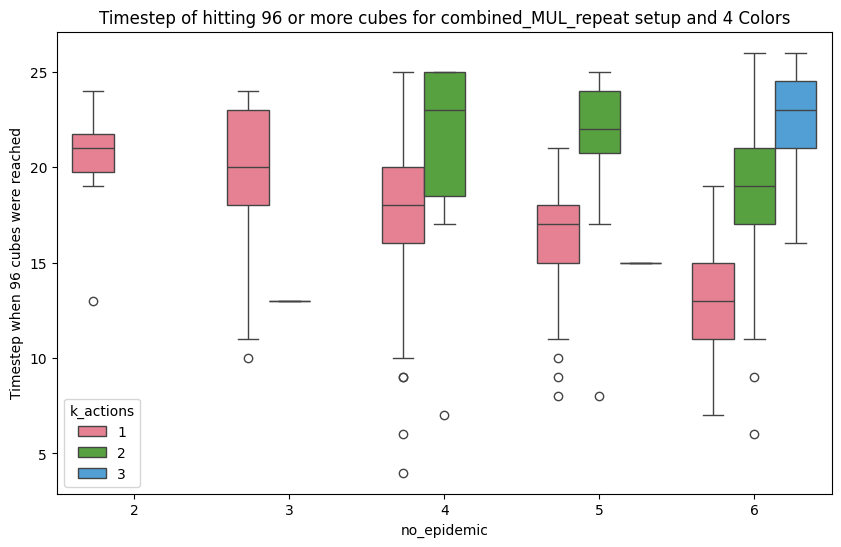

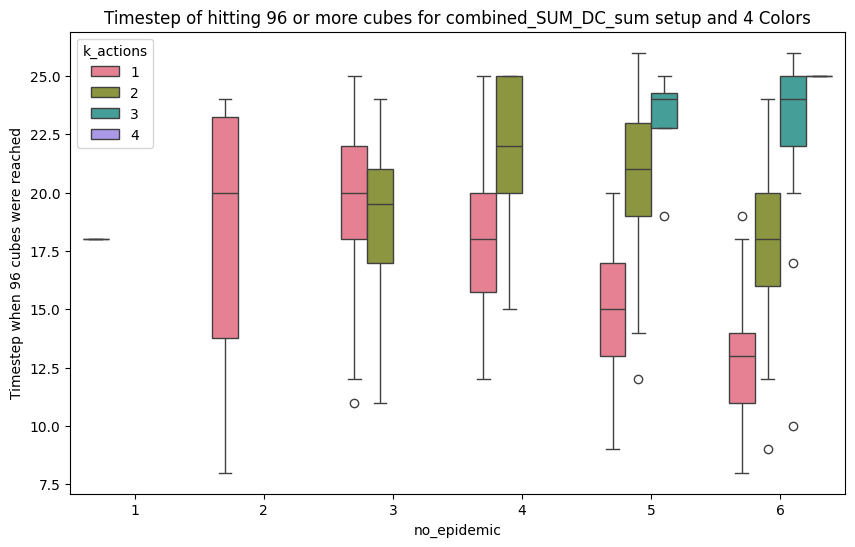

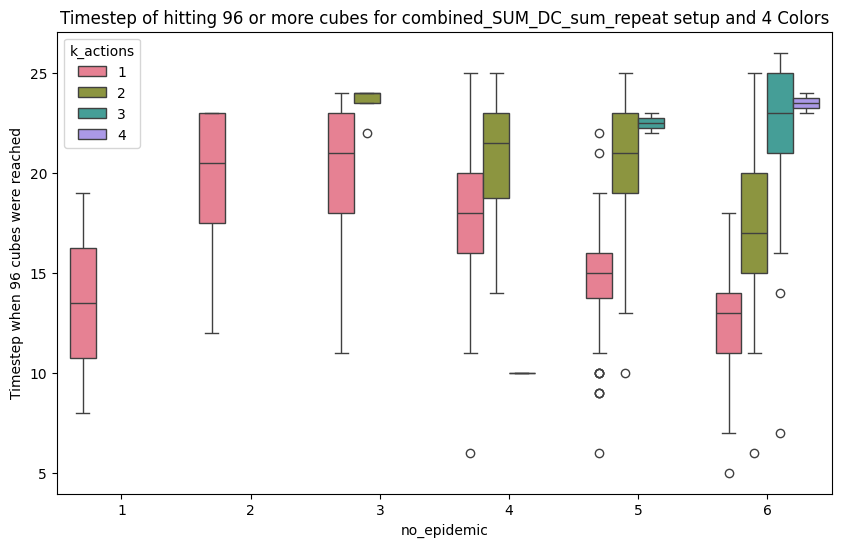

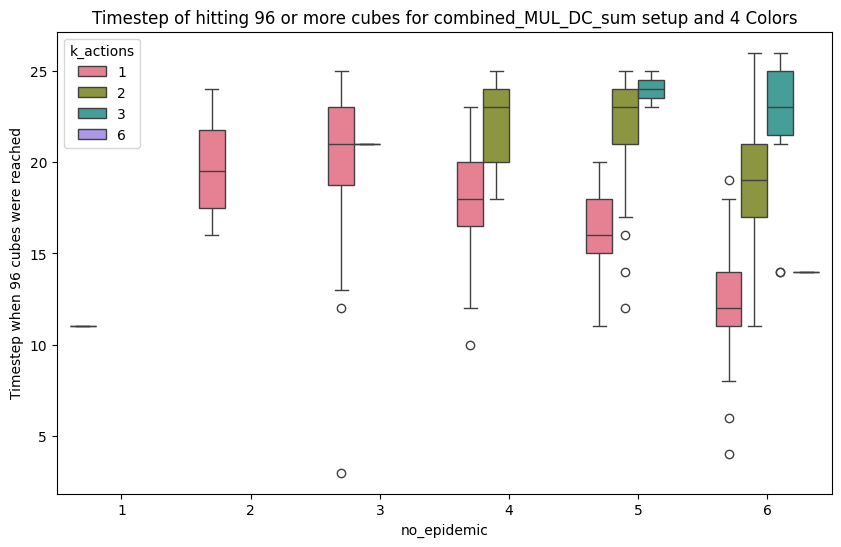

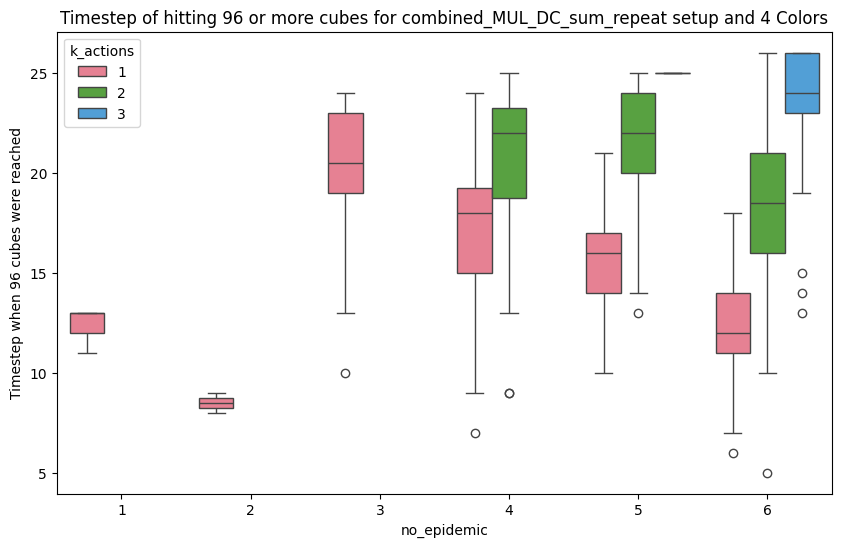

In [ ]:
for strategy in strategies:
    strategy_df = pd.read_csv(f'{strategy}_4Colors.csv')

    # Define the setup name
    setup_name = strategy

    # Call the function with your baseline_df and setup_name
    calculate_96_cube_boxplot(strategy_df, setup_name)

In [ ]:
#@title 8 or more outbreaks lose condition boxplot

def calculate_8_outbreaks_heatmap(df, setup_name, condition_column, threshold):
    # Define the unique values of 'no_epidemic' and 'k_actions'
    unique_no_epidemics = sorted(df['no_epidemic'].unique())
    unique_k_actions = sorted(df['k_actions'].unique())

    # Initialize a 2D array to store probabilities
    probabilities = np.zeros((len(unique_k_actions), len(unique_no_epidemics)))  # Swapping dimensions

    # Iterate over all combinations of 'no_epidemic' and 'k_actions'
    for i, no_epi in enumerate(unique_no_epidemics):
        for j, k_act in enumerate(unique_k_actions):  # Adjusted indices
            # Filter the DataFrame based on the current combination
            filtered_df = df[(df['no_epidemic'] == no_epi) & (df['k_actions'] == k_act)]

            # Initialize counter for this combination
            count = 0

            # Iterate over each run in the filtered DataFrame
            for _, run in filtered_df.groupby('run'):
                # Check if any timestep within the run meets the condition
                if (run[condition_column] >= threshold).any():
                    count += 1

            # Calculate the probability
            probability = count / 100

            # Store the probability in the 2D array
            probabilities[j, i] = probability

    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(probabilities, cmap='coolwarm', annot=True, xticklabels=unique_no_epidemics, yticklabels=unique_k_actions)
    plt.xlabel('no_epidemic')
    plt.ylabel('k_actions')
    plt.title(f'Probability of hitting {threshold} or more {condition_column} for {setup_name} setup and 4 Colors')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))  # Adjust the position of the legend
    plt.savefig((f'{setup_name}_4Colors_Heatmap_8_or_more_Outbreaks.png'), bbox_inches='tight')
    plt.show()

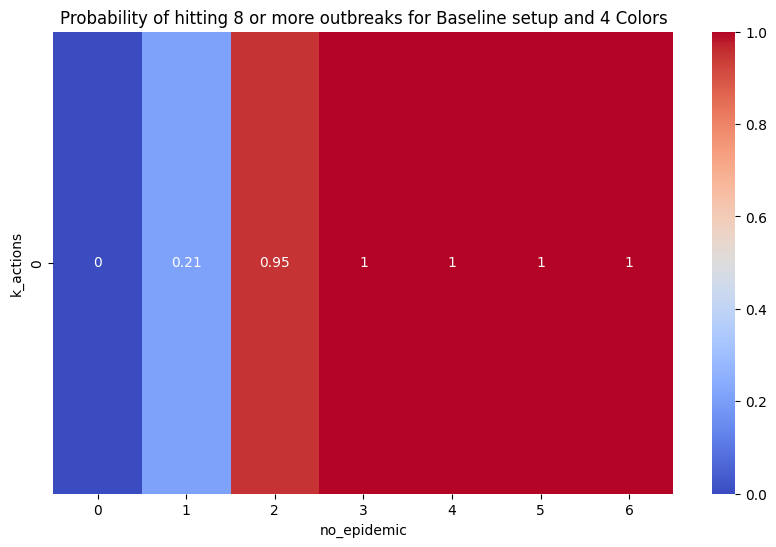

In [ ]:
baseline_df = pd.read_csv('Baseline_4Colors.csv')

# Define the setup name
setup_name = "Baseline"

# Call the function with your baseline_df and setup_name
calculate_8_outbreaks_heatmap(baseline_df, setup_name, "outbreaks", 8)

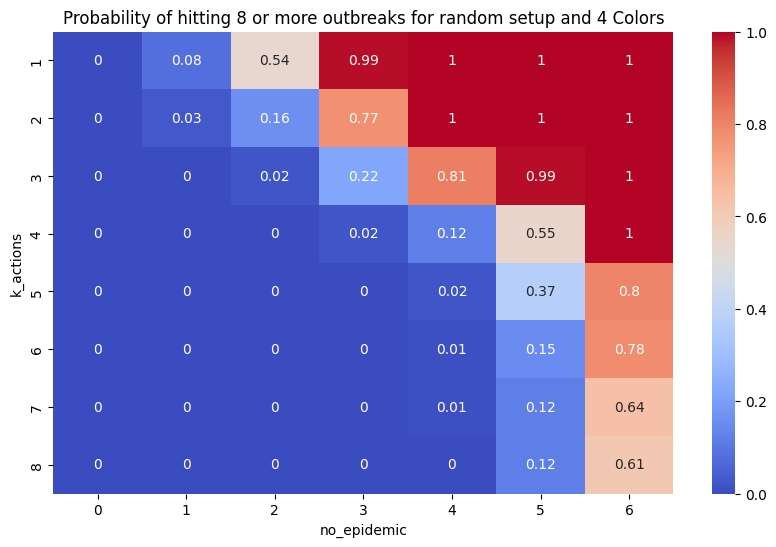

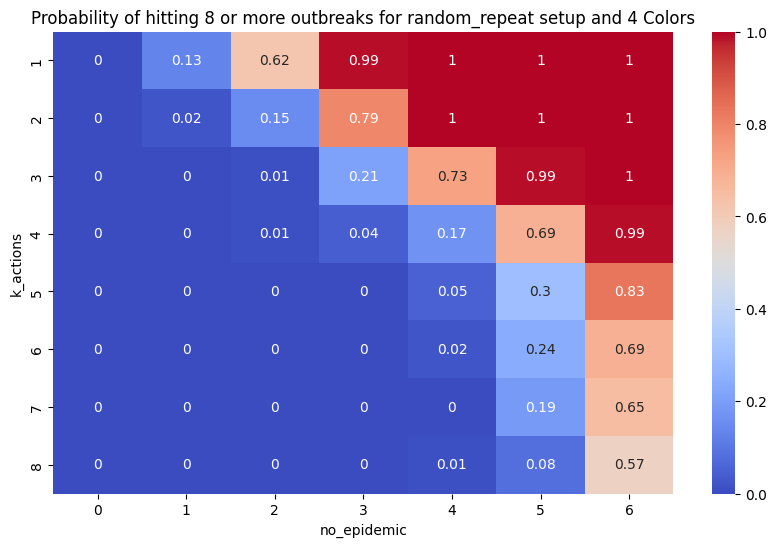

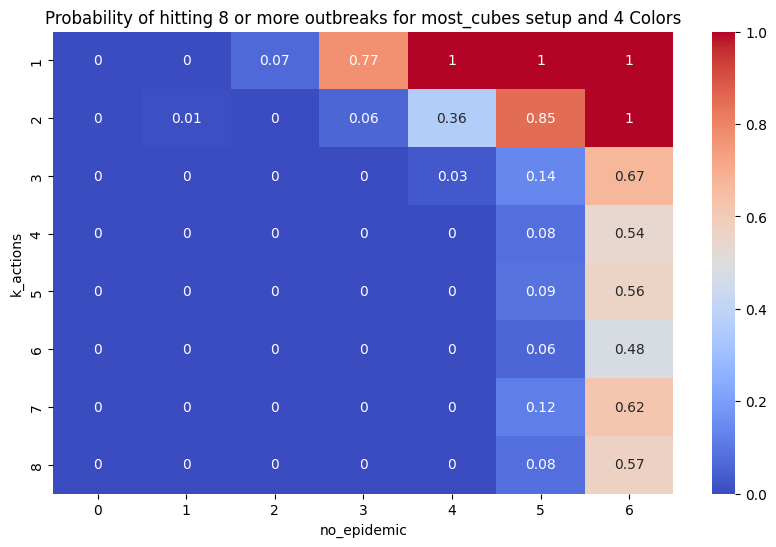

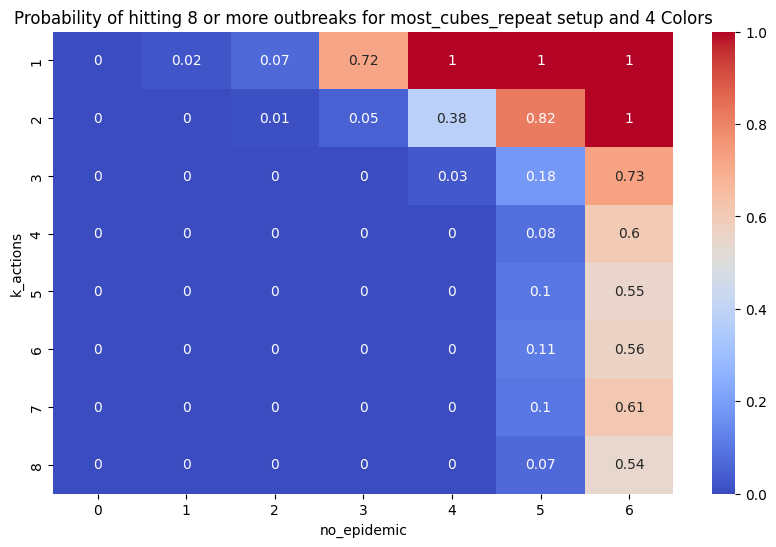

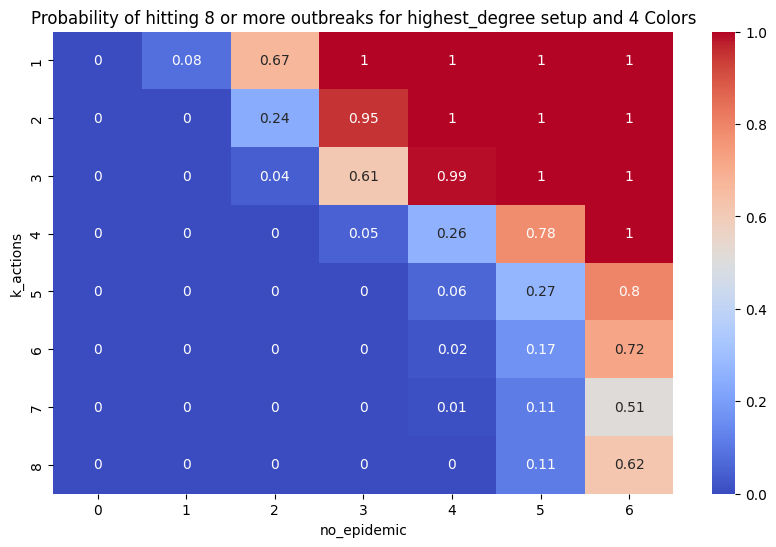

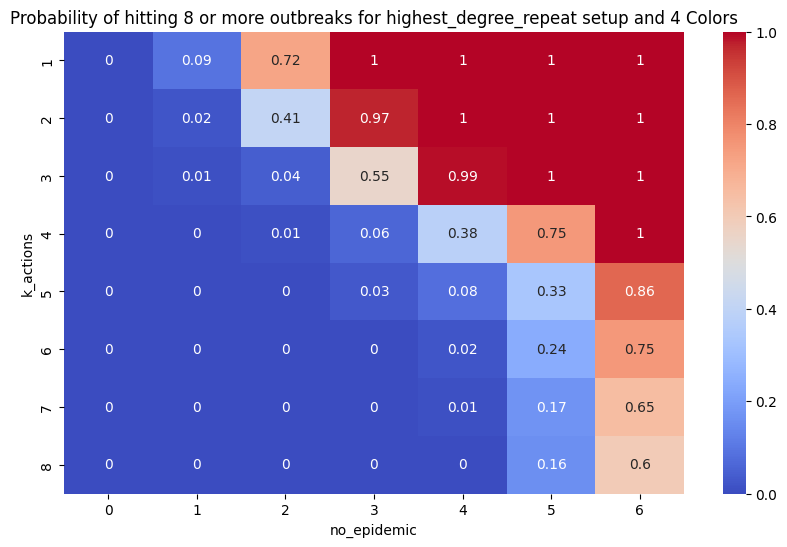

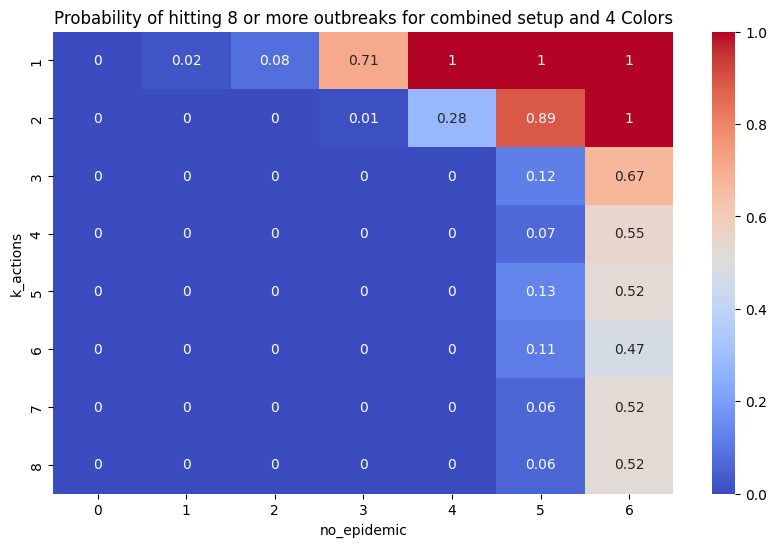

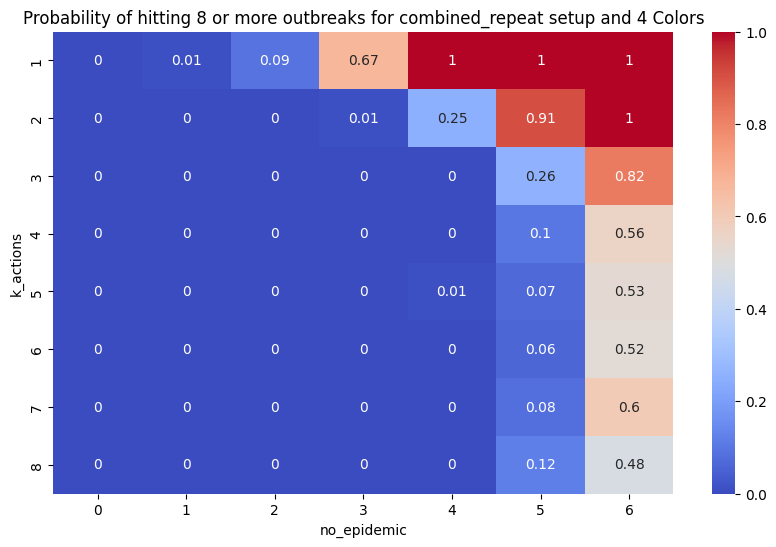

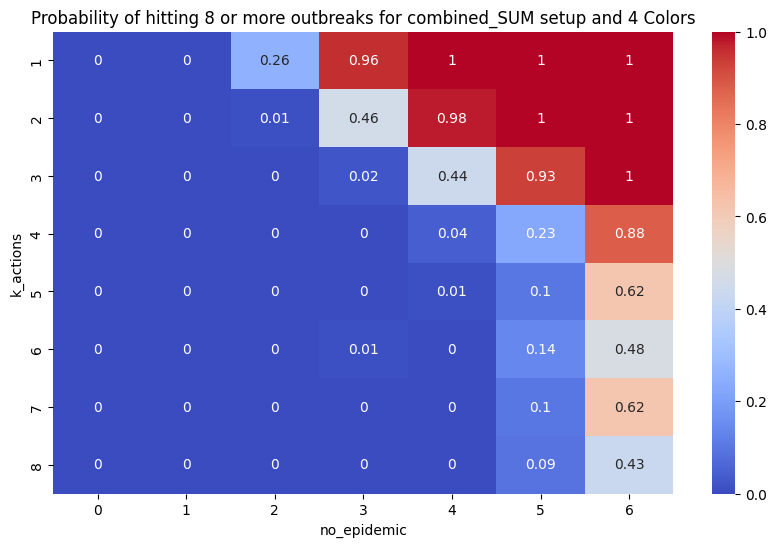

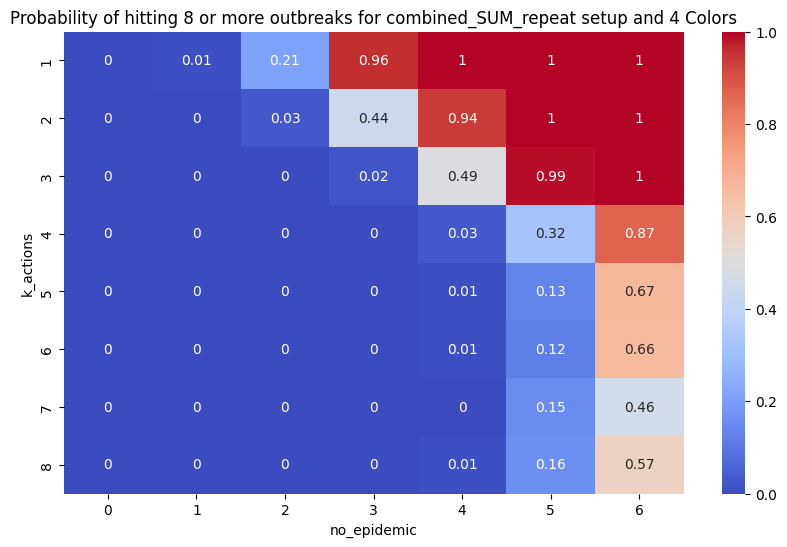

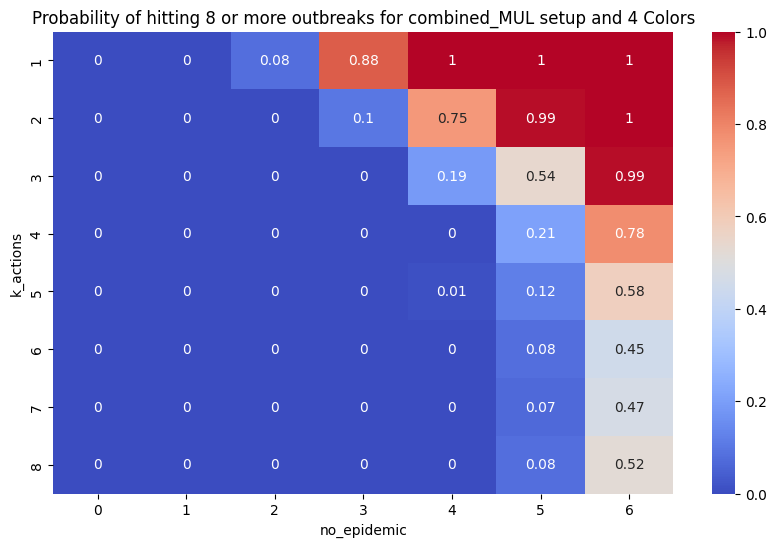

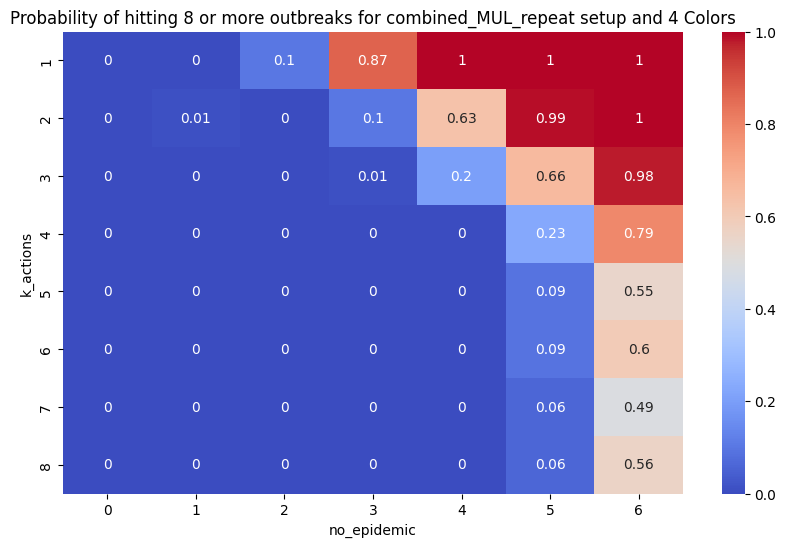

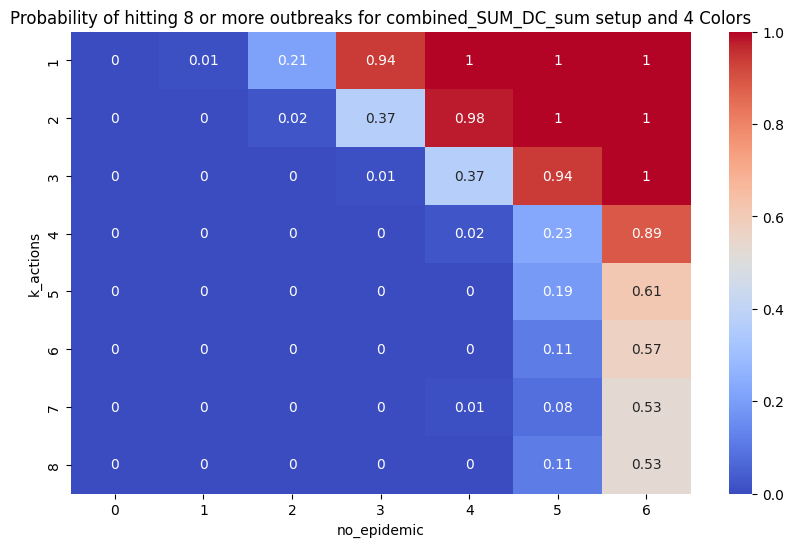

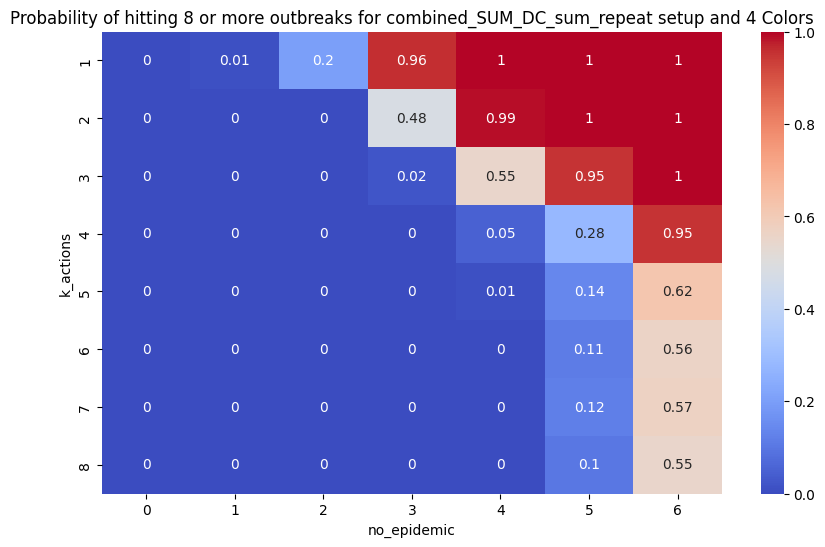

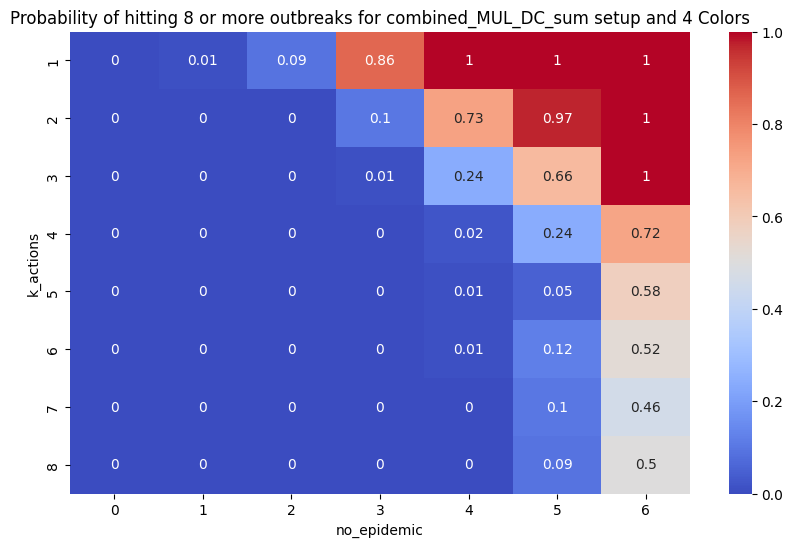

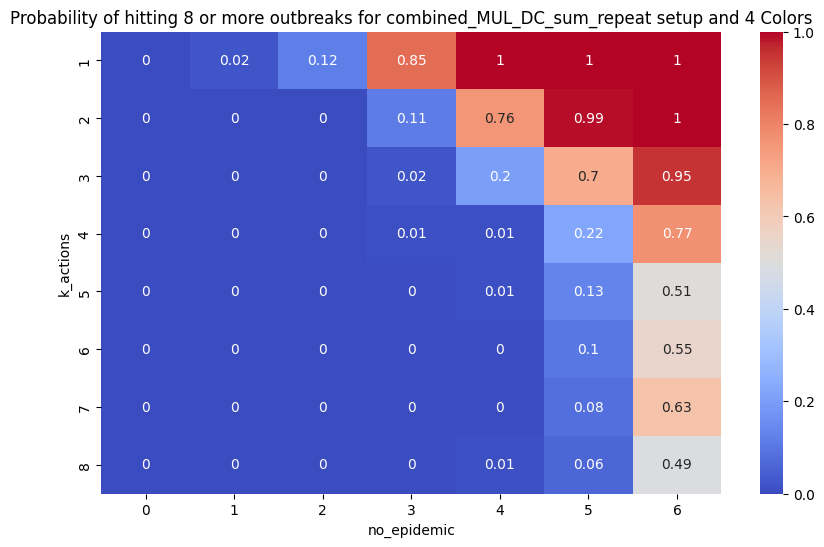

In [ ]:
for strategy in strategies:
    strategy_df = pd.read_csv(f'{strategy}_4Colors.csv')

    # Define the setup name
    setup_name = strategy

    # Call the function with your baseline_df and setup_name
    calculate_8_outbreaks_heatmap(strategy_df, setup_name, "outbreaks", 8)

In [ ]:
def calculate_8_outbreaks_boxplot(df, setup_name):
    # Define the unique values of 'no_epidemic' and 'k_actions'
    unique_no_epidemics = sorted(df['no_epidemic'].unique())
    unique_k_actions = sorted(df['k_actions'].unique())

    # Initialize an empty list to store timestep data
    timestep_data = []

    # Iterate over all combinations of 'no_epidemic' and 'k_actions'
    for no_epi in unique_no_epidemics:
        for k_act in unique_k_actions:
            # Filter the DataFrame based on the current combination
            filtered_df = df[(df['no_epidemic'] == no_epi) & (df['k_actions'] == k_act)]

            # Iterate over each run in the filtered DataFrame
            for _, run in filtered_df.groupby('run'):
                # Calculate the total number of cubes for each timestep in the run
                outbreaks = run['outbreaks']
                # Check if any timestep within the run has 96 or more cubes
                if (outbreaks >= 8).any():
                    # Get the timestep where the condition is met
                    timestep = run.loc[outbreaks >= 8, 'timestep'].iloc[0]
                    timestep_data.append({'no_epidemic': no_epi, 'k_actions': k_act, 'timestep': timestep})

    # Create a DataFrame from the timestep data
    timestep_df = pd.DataFrame(timestep_data)

    # Saving DataFrame to CSV file
    # timestep_df.to_csv('timestep_df.csv', index=False)

    # Create the box plot
    num_colors = len(timestep_df['k_actions'].unique())
    palette = sns.color_palette("husl", num_colors)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=timestep_df, x='no_epidemic', y='timestep', hue='k_actions', palette=palette)
    plt.xlabel('no_epidemic')
    plt.ylabel('Timestep when 8 Outbreaks were reached')
    plt.title(f'Timestep of hitting 8 or more outbreaks for {setup_name} setup and 4 Colors')
    plt.savefig((f'{setup_name}_4Colors_Boxplot_8_or_more_Outbreaks.png'))
    plt.show()

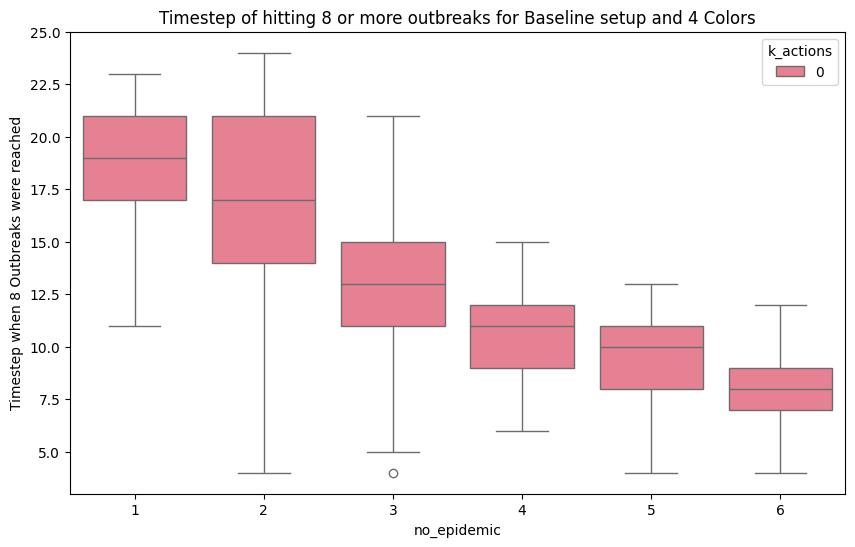

In [ ]:
baseline_df = pd.read_csv('Baseline_4Colors.csv')

# Define the setup name
setup_name = "Baseline"

# Call the function with your baseline_df and setup_name
calculate_8_outbreaks_boxplot(baseline_df, setup_name)

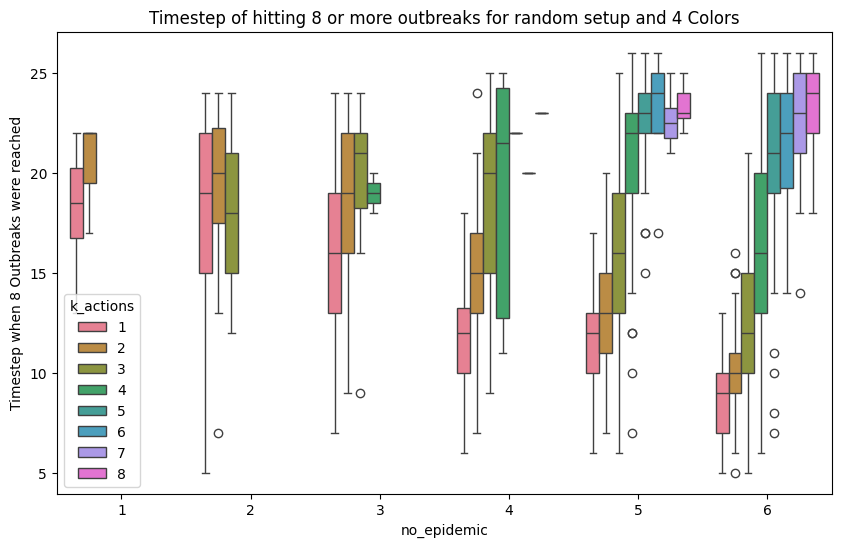

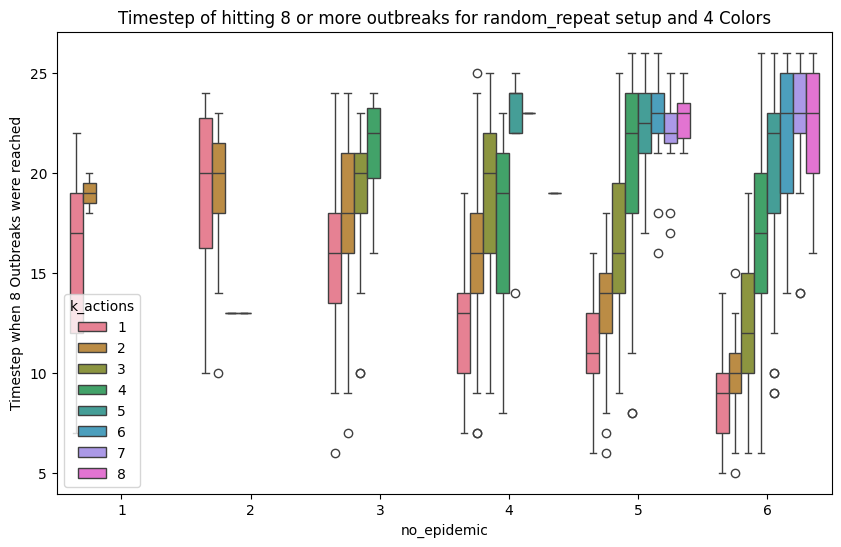

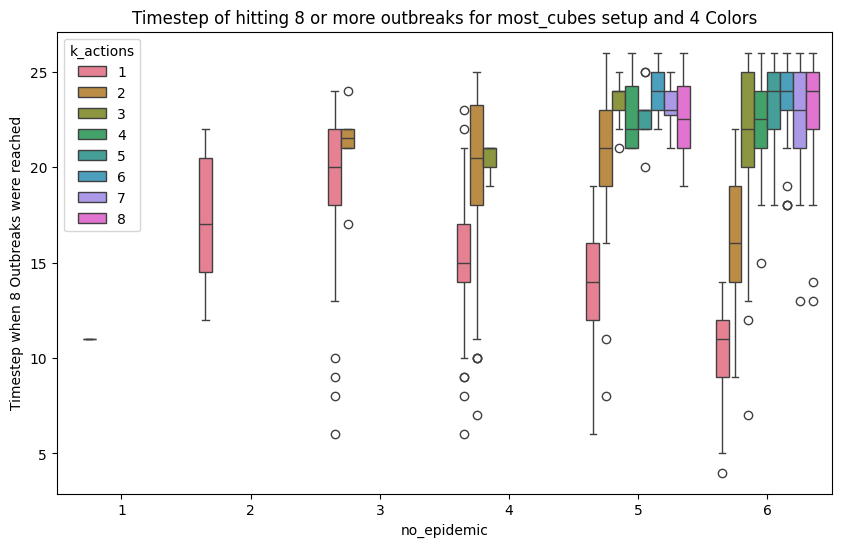

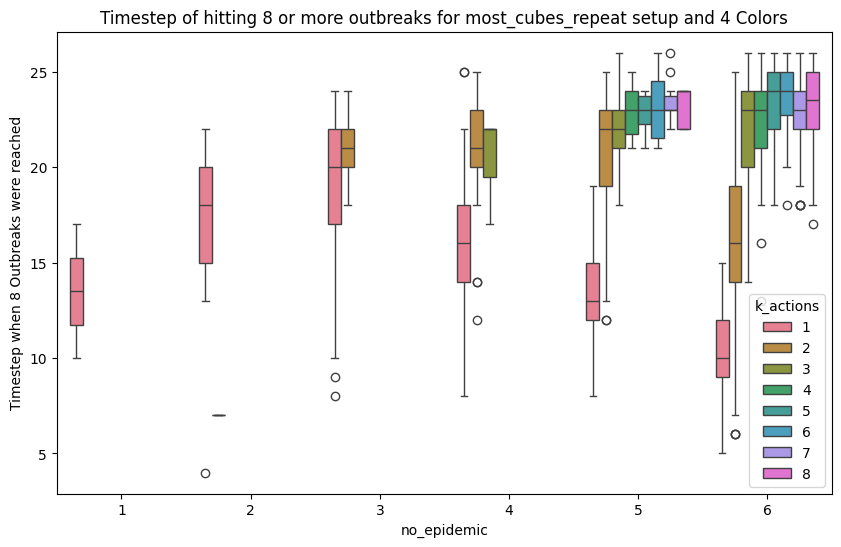

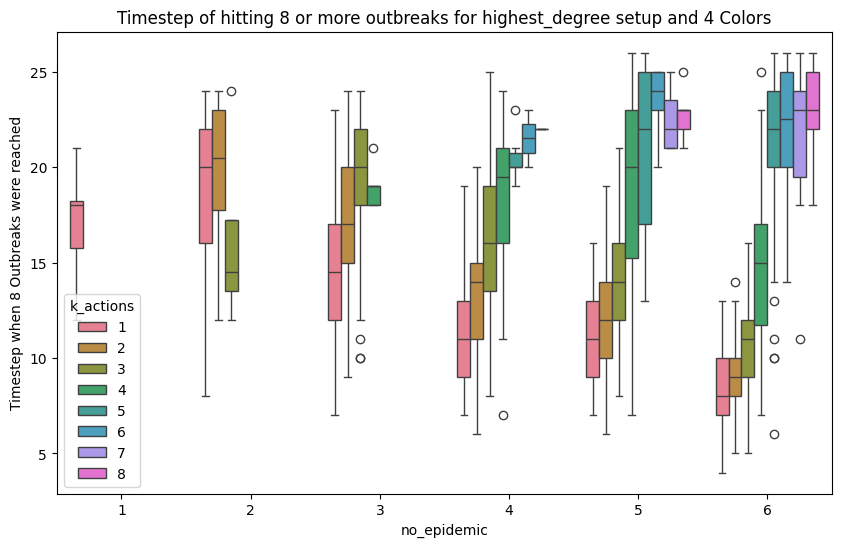

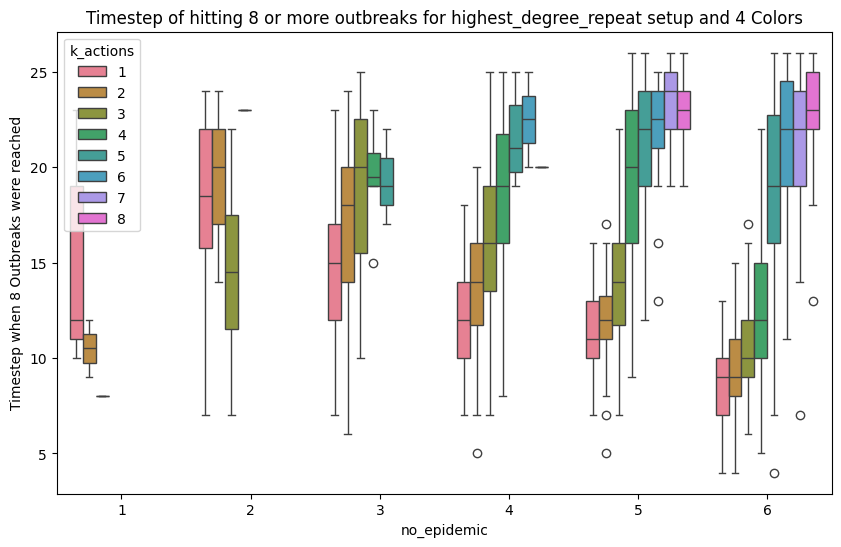

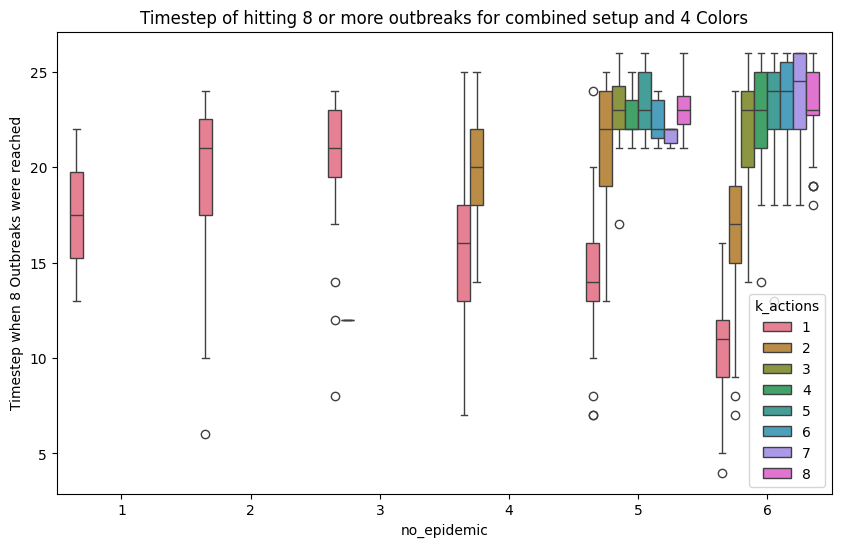

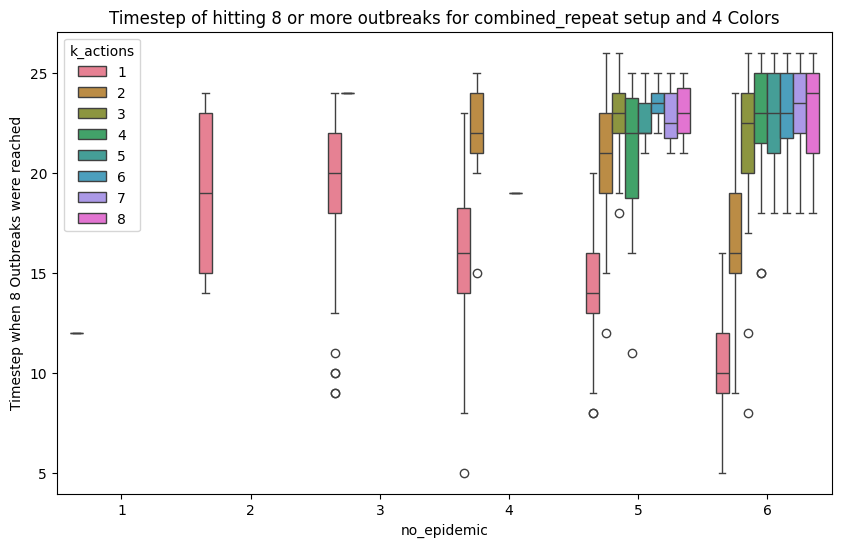

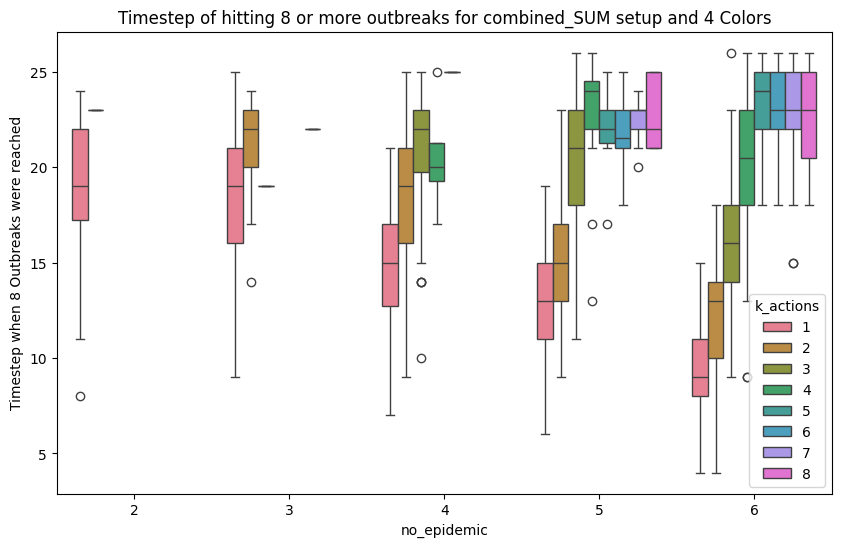

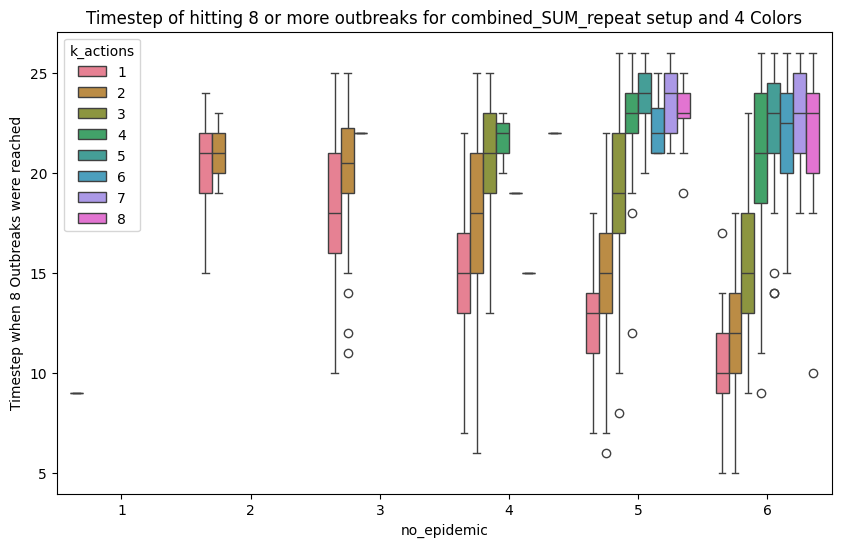

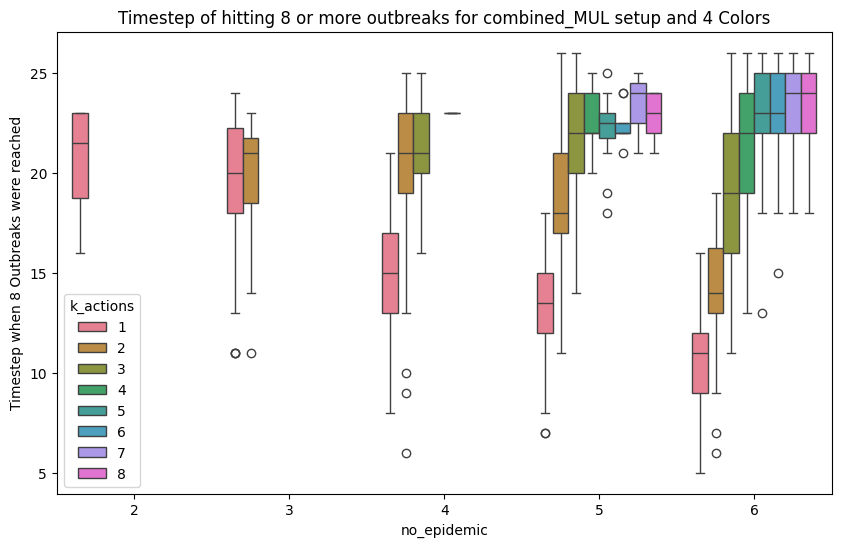

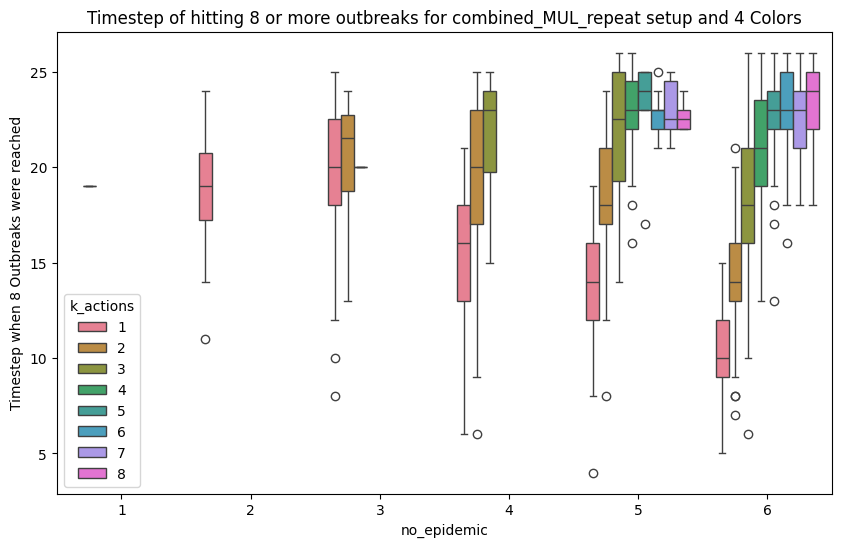

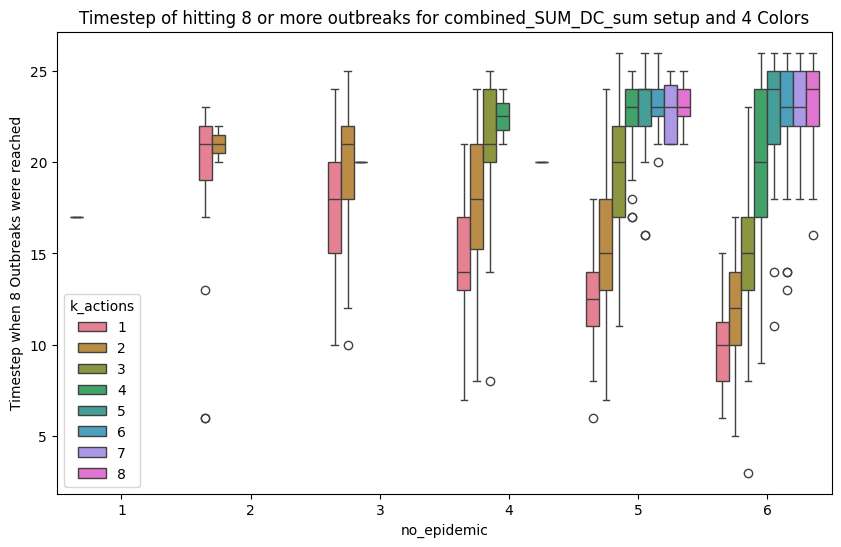

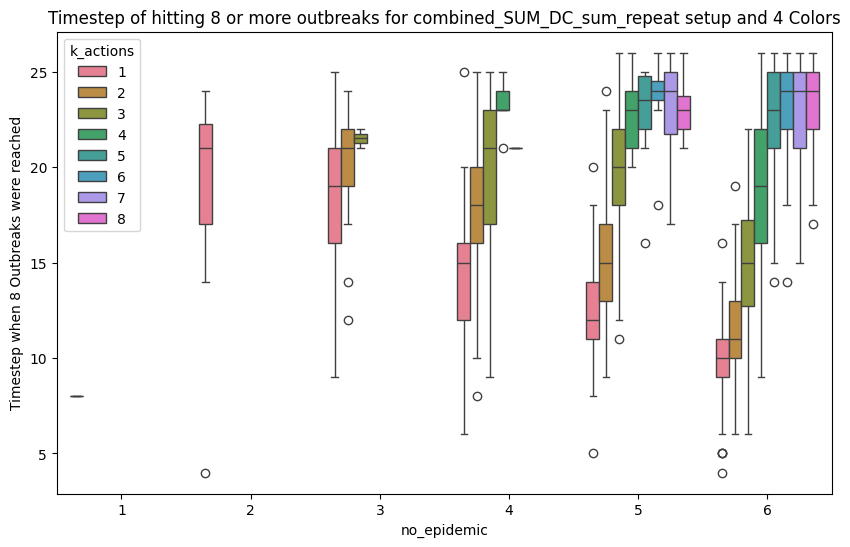

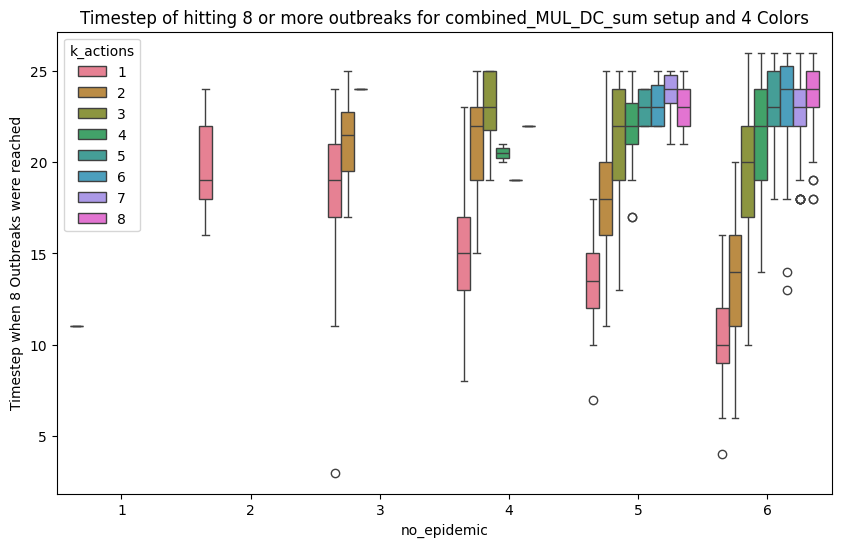

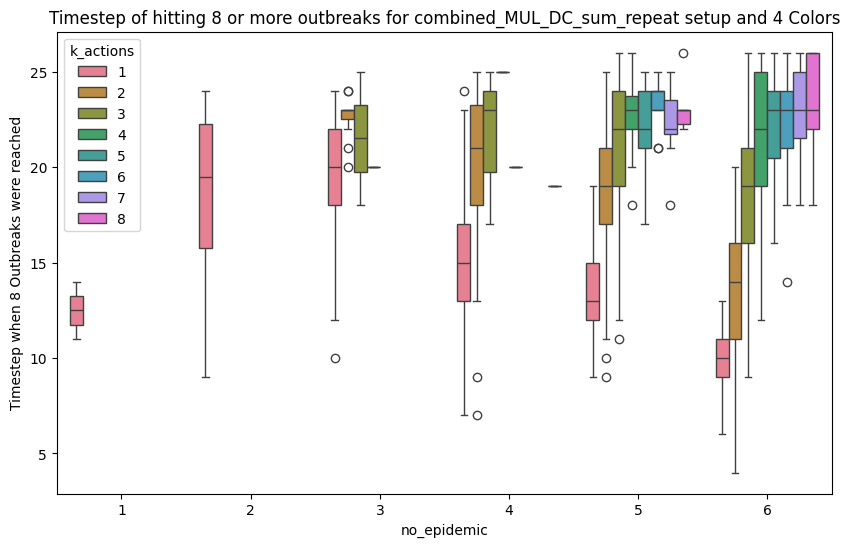

In [ ]:
for strategy in strategies:
    strategy_df = pd.read_csv(f'{strategy}_4Colors.csv')

    # Define the setup name
    setup_name = strategy

    # Call the function with your baseline_df and setup_name
    calculate_8_outbreaks_boxplot(strategy_df, setup_name)

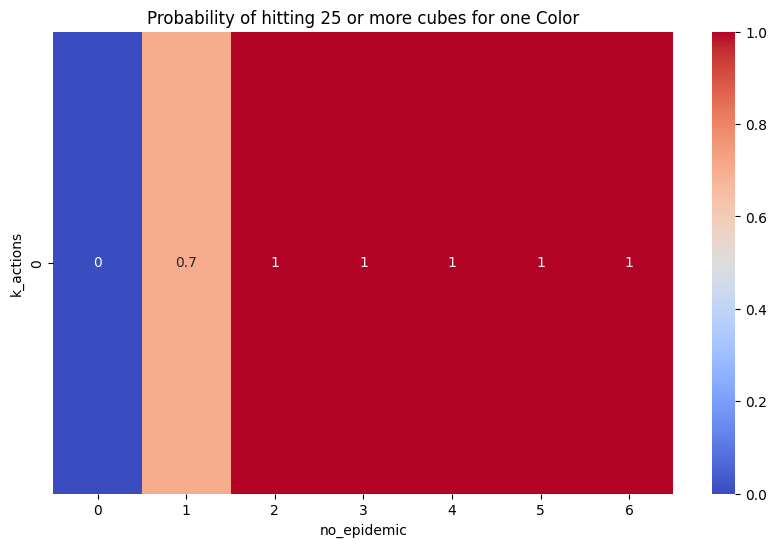

In [ ]:
#@title Baseline lose condition 25 cubes heatmap
baseline_df = pd.read_csv('Baseline_4Colors.csv')

# Initialize a 2D array to store probabilities
# 0 Actions for baseline
probabilities = np.zeros((len([0]), len(epidemic_cards)))  # Swapping dimensions

# Iterate over all combinations of 'no_epidemic' and 'k_actions'
for i, no_epi in enumerate(epidemic_cards):
    for j, k_act in enumerate([0]):  # Adjusted indices
        # Filter the DataFrame based on the current combination
        filtered_df = baseline_df[(baseline_df['no_epidemic'] == no_epi) & (baseline_df['k_actions'] == k_act)]

        # Initialize counter for this combination
        # I dont know any heatmap that i could divide into 4 counters for each epi and k_action
        # So I used the normal count var
        blue_count = 0
        yellow_count = 0
        red_count = 0
        black_count = 0
        count = 0

        # Iterate over each run in the filtered DataFrame
        for _, run in filtered_df.groupby('run'):
            # Calculate the total number of cubes for each timestep in the run
            blue_cubes = (run['infection_1_nodes_blue'] + 2 * run['infection_2_nodes_blue'] + 3 * run['infection_3_nodes_blue'])
            yellow_cubes = (run['infection_1_nodes_yellow'] + 2 * run['infection_2_nodes_yellow'] + 3 * run['infection_3_nodes_yellow'])
            red_cubes = (run['infection_1_nodes_red'] + 2 * run['infection_2_nodes_red'] + 3 * run['infection_3_nodes_red'])
            black_cubes = (run['infection_1_nodes_black'] + 2 * run['infection_2_nodes_black'] + 3 * run['infection_3_nodes_black'])
            # Check if any timestep within the run has 96 or more cubes
            #if (blue_cubes >= 25 or yellow_cubes >= 25 or red_cubes >= 25 or black_cubes >= 25).any():
            #    count += 1
            if (blue_cubes >= 25).any():
                count += 1
            elif (yellow_cubes >= 25).any():
                count += 1
            elif (red_cubes >= 25).any():
                count += 1
            elif (black_cubes >= 25).any():
                count += 1

        # Calculate the probability
        probability = count / 100

        # Store the probability in the 2D array
        probabilities[j, i] = probability

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(probabilities, cmap='coolwarm', annot=True, xticklabels=epidemic_cards, yticklabels=[0])
plt.xlabel('no_epidemic')
plt.ylabel('k_actions')
plt.title('Probability of hitting 25 or more cubes for one Color')
plt.savefig((f'Baseline_4Color_Probability_of_hitting_25_or_more_cubes.png'))
plt.show()

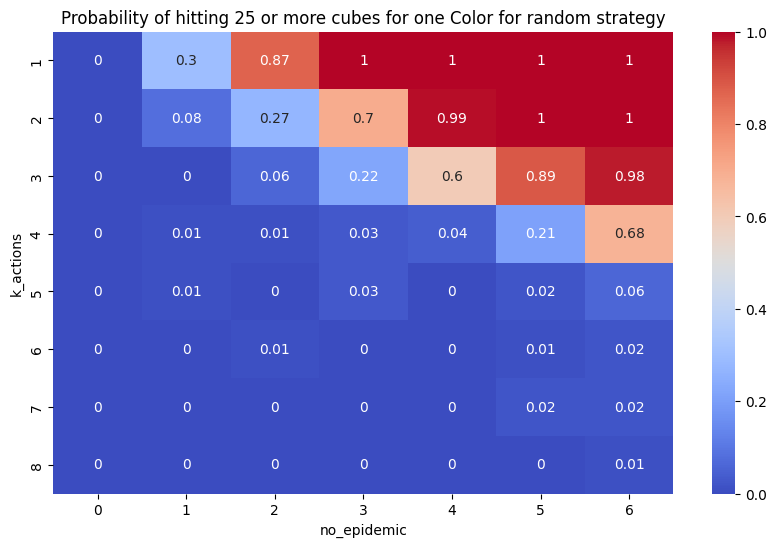

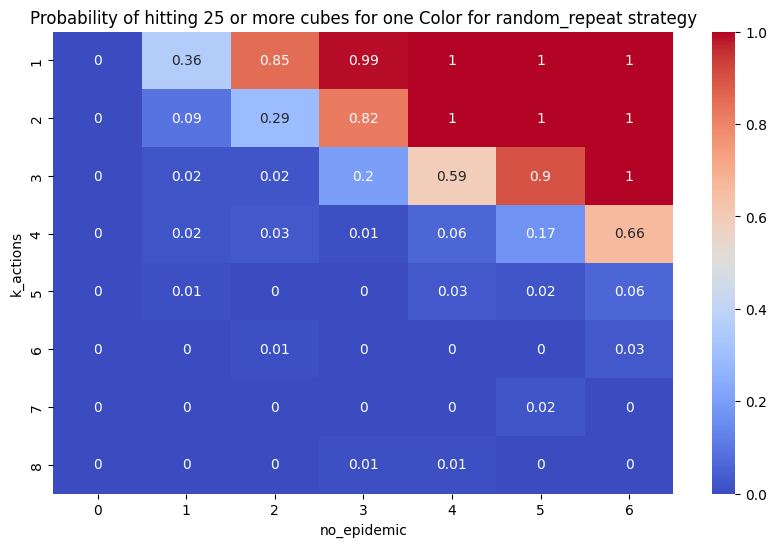

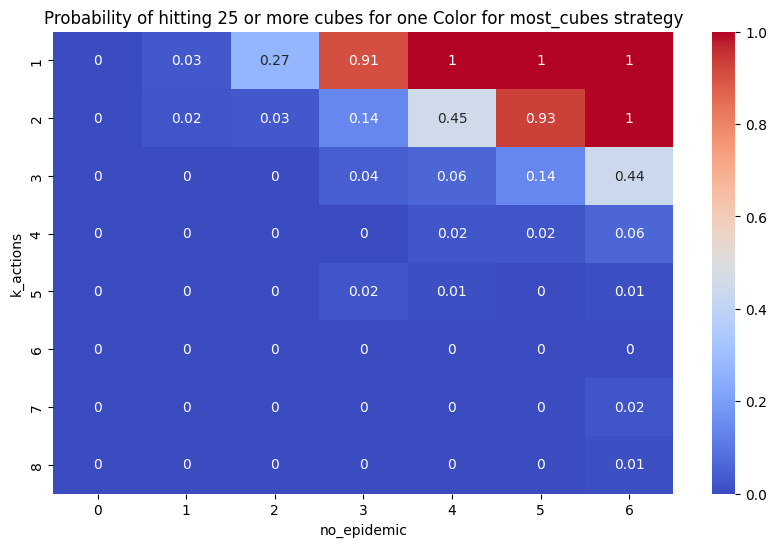

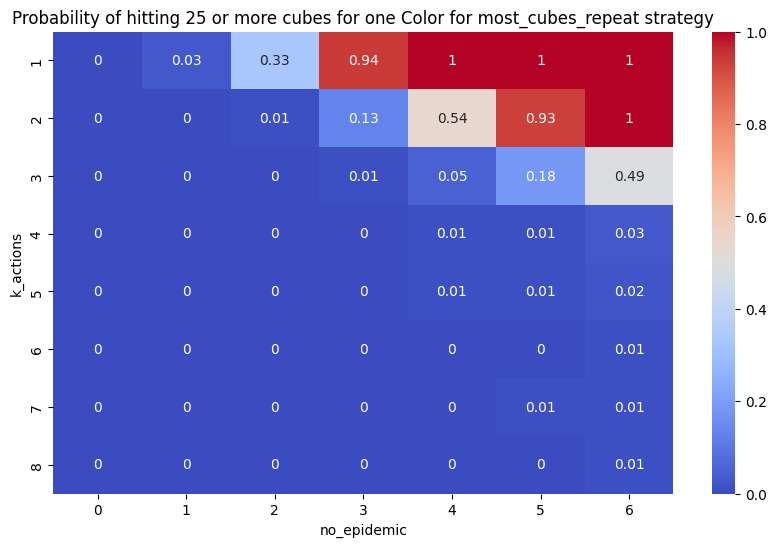

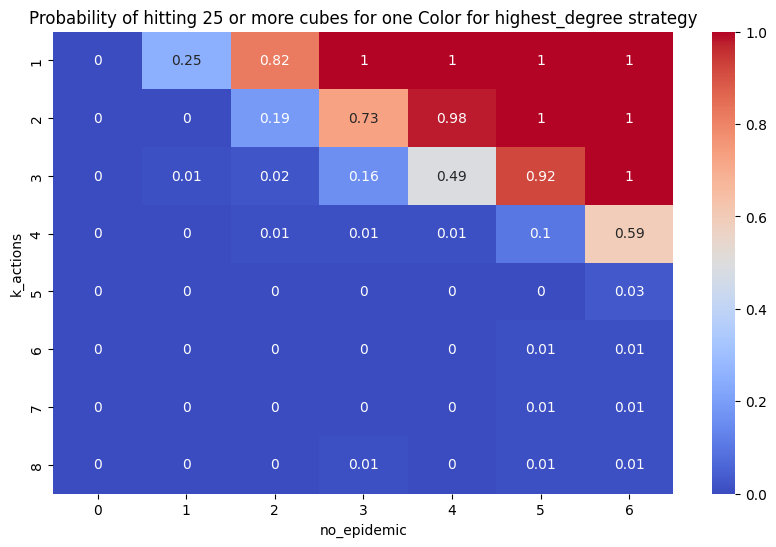

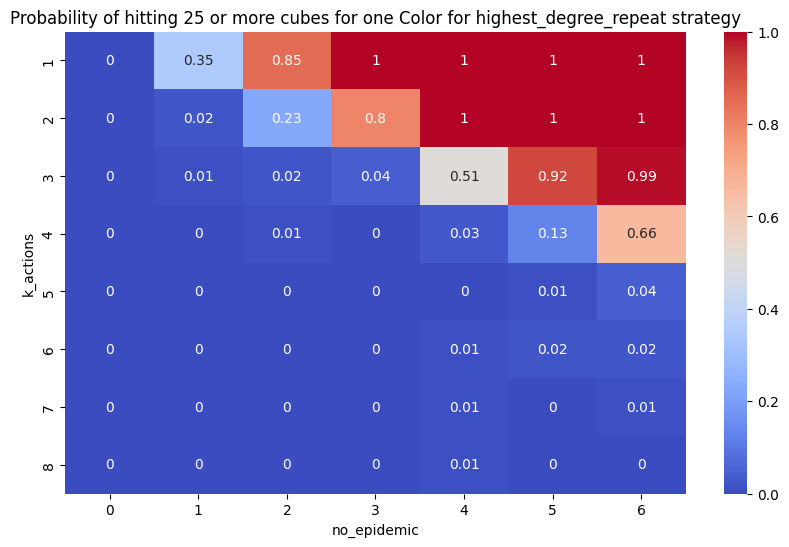

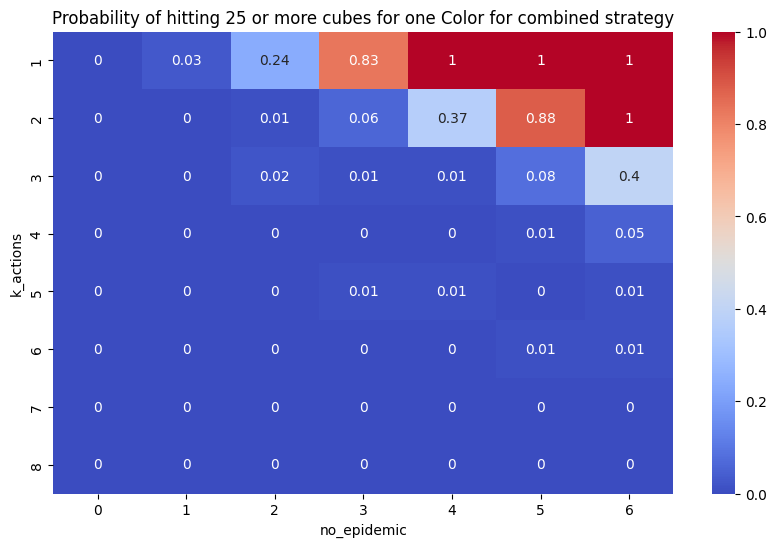

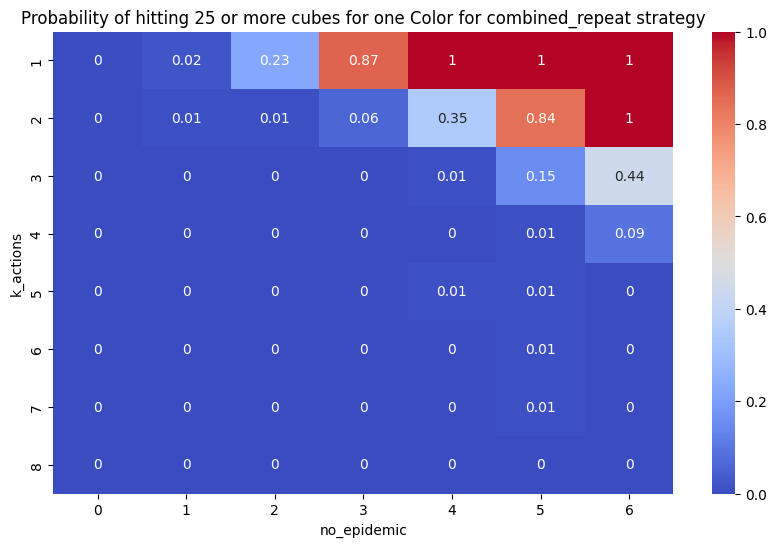

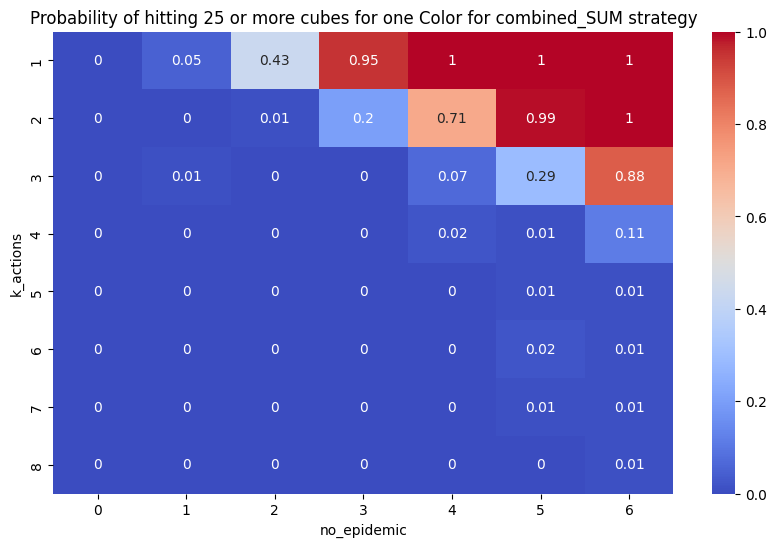

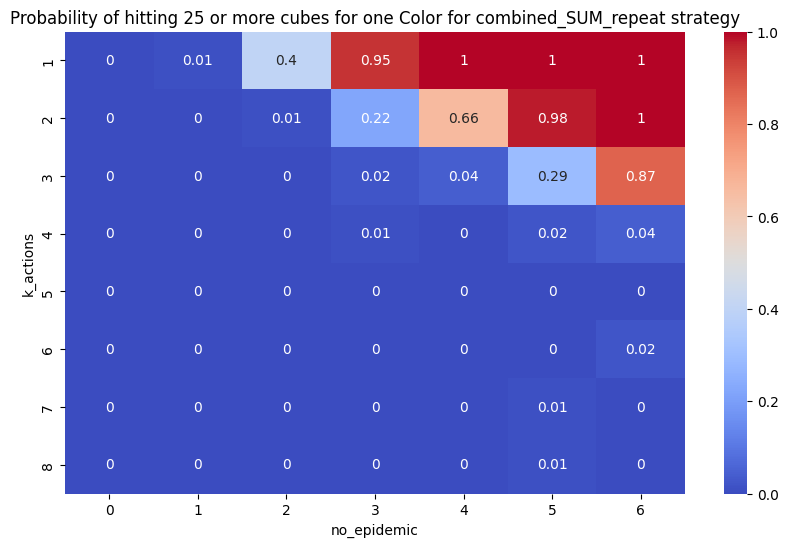

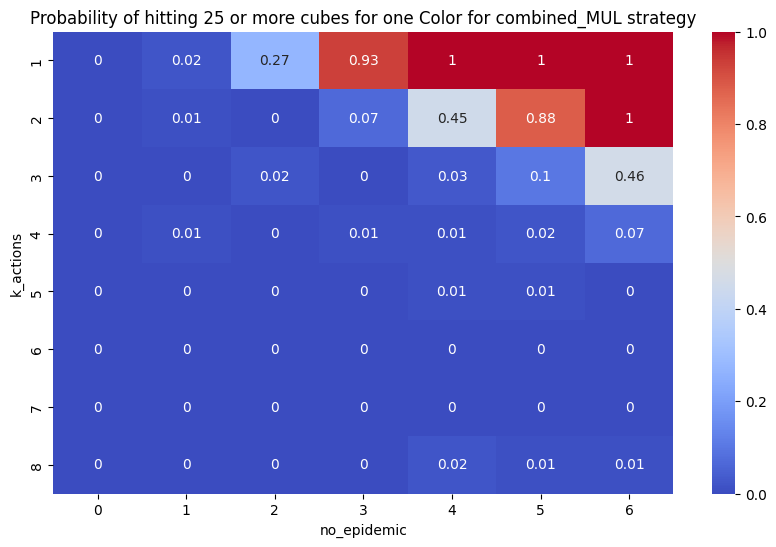

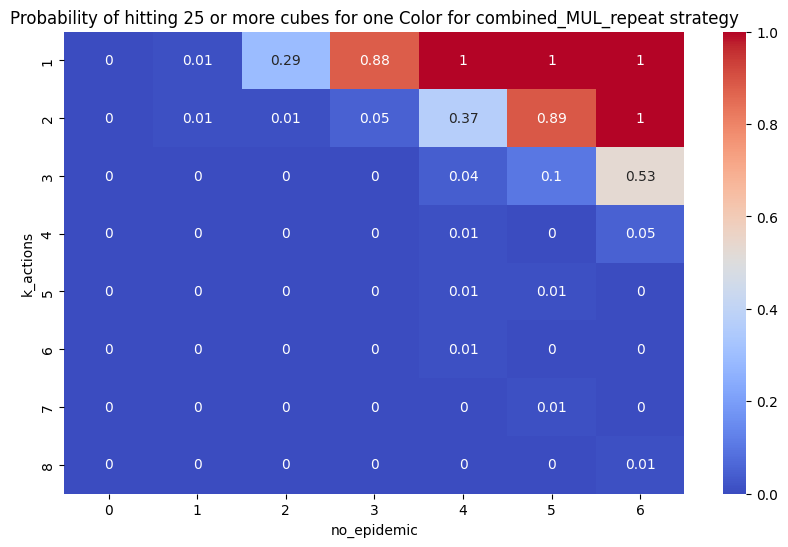

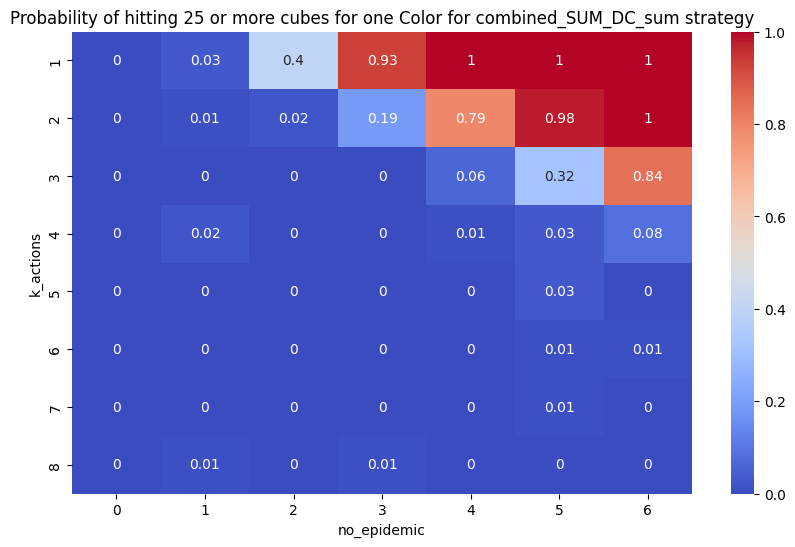

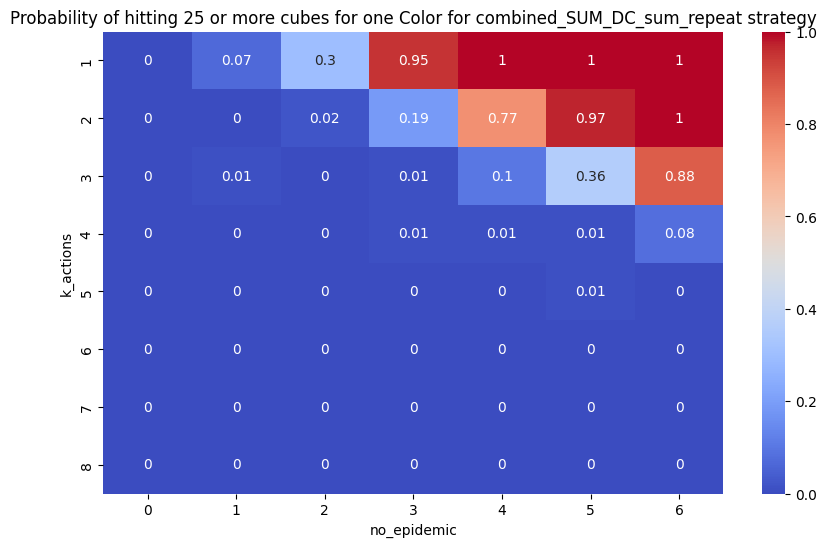

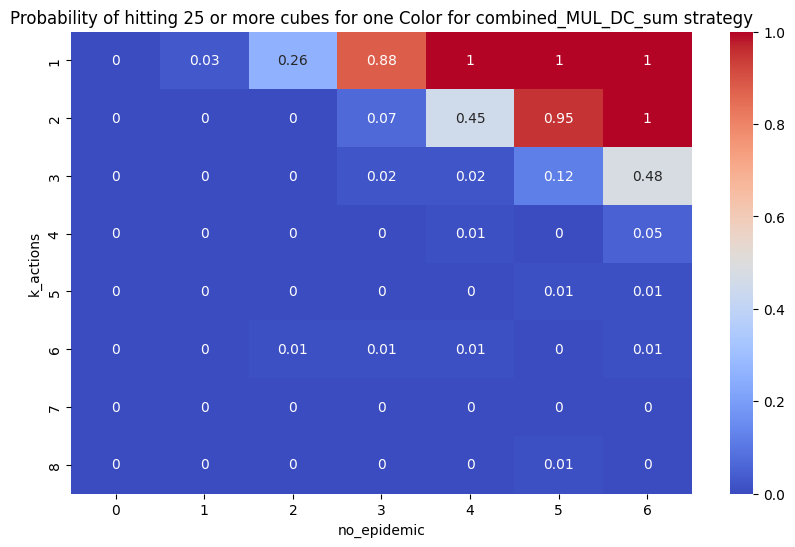

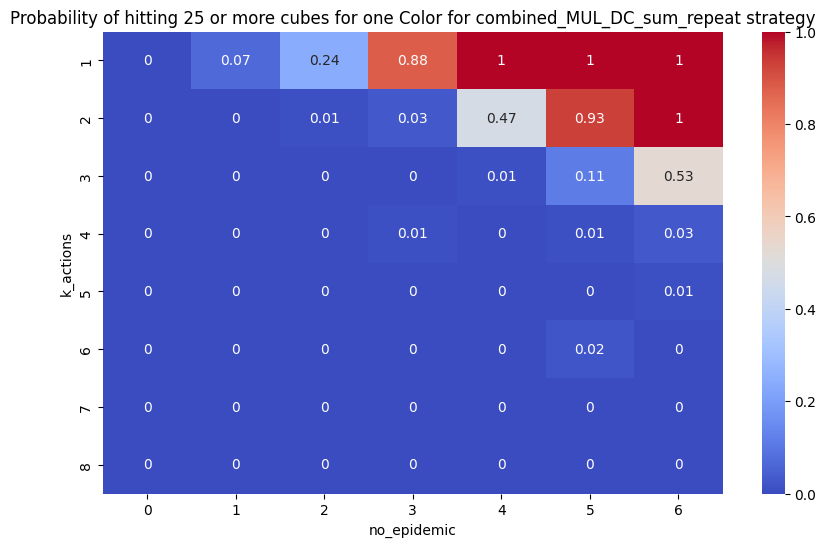

In [ ]:
for strategy in strategies:
    strategy_df = pd.read_csv(f'{strategy}_4Colors.csv')

    unique_k_actions = sorted(strategy_df['k_actions'].unique())

    # Initialize a 2D array to store probabilities
    probabilities = np.zeros((len(unique_k_actions), len(epidemic_cards)))

    # Iterate over all combinations of 'no_epidemic' and 'k_actions'
    for i, no_epi in enumerate(epidemic_cards):
        for j, k_act in enumerate(unique_k_actions):
            # Filter the DataFrame based on the current combination
            filtered_df = strategy_df[(strategy_df['no_epidemic'] == no_epi) & (strategy_df['k_actions'] == k_act)]

            # Initialize counter for this combination
            # I dont know any heatmap that i could divide into 4 counters for each epi and k_action
            # So I used the normal count var
            blue_count = 0
            yellow_count = 0
            red_count = 0
            black_count = 0
            count = 0

            # Iterate over each run in the filtered DataFrame
            for _, run in filtered_df.groupby('run'):
                # Calculate the total number of cubes for each timestep in the run
                blue_cubes = (run['infection_1_nodes_blue'] + 2 * run['infection_2_nodes_blue'] + 3 * run['infection_3_nodes_blue'])
                yellow_cubes = (run['infection_1_nodes_yellow'] + 2 * run['infection_2_nodes_yellow'] + 3 * run['infection_3_nodes_yellow'])
                red_cubes = (run['infection_1_nodes_red'] + 2 * run['infection_2_nodes_red'] + 3 * run['infection_3_nodes_red'])
                black_cubes = (run['infection_1_nodes_black'] + 2 * run['infection_2_nodes_black'] + 3 * run['infection_3_nodes_black'])
                # Check if any timestep within the run has 96 or more cubes
                #if (blue_cubes >= 25 or yellow_cubes >= 25 or red_cubes >= 25 or black_cubes >= 25).any():
                #    count += 1
                if (blue_cubes >= 25).any():
                    count += 1
                elif (yellow_cubes >= 25).any():
                    count += 1
                elif (red_cubes >= 25).any():
                    count += 1
                elif (black_cubes >= 25).any():
                    count += 1

            # Calculate the probability
            probability = count / 100

            # Store the probability in the 2D array
            probabilities[j, i] = probability

    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(probabilities, cmap='coolwarm', annot=True, xticklabels=epidemic_cards, yticklabels=unique_k_actions)
    plt.xlabel('no_epidemic')
    plt.ylabel('k_actions')
    plt.title(f'Probability of hitting 25 or more cubes for one Color for {strategy} strategy')
    plt.savefig((f'{strategy}_4Colors_Probability_of_hitting_25_or_more_cubes_for_one_Color.png'))
    plt.show()

In [ ]:
#Debug
# network, strategy, steps
simulate_pandemic(initialize_pandemic_model(Graph_gameboard, "most_cubes"), 27)